In [1]:
# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques standards
import numpy as np
import pandas as pd
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement des données
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Séparation des données et validation croisée
from sklearn.model_selection import train_test_split, StratifiedKFold

# Modèles de classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Évaluation des modèles
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Charger les données :

# pour chéques
df1 = pd.read_excel('/content/drive/MyDrive/données_chèque_stage.xls')
# pour lettres de change
df2 = pd.read_excel('/content/drive/MyDrive/données_LDC_stage.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [4]:
# Vérifier les premières lignes
df1.head()

# Vérifier les informations sur le dataset
df1.info()

# Vérifier les statistiques descriptives
df1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50253 entries, 0 to 50252
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NBRE         50213 non-null  float64       
 1   MCR          50213 non-null  float64       
 2   MDB          50213 non-null  float64       
 3   VALEUR       50253 non-null  int64         
 4   DATECPS      50253 non-null  datetime64[ns]
 5   NUM          50253 non-null  int64         
 6   MNT          49521 non-null  float64       
 7   ID           50253 non-null  int64         
 8   DNA          31752 non-null  object        
 9   PROVISIONNE  21391 non-null  float64       
 10  PROFESSION   41528 non-null  object        
 11  LIBCCL       50236 non-null  object        
 12  SORT         50253 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 5.0+ MB


,NBRE,MCR,MDB,VALEUR,DATECPS,NUM,MNT,ID,PROVISIONNE
count,50213.000000,5.021300e+04,5.021300e+04,50253.0,50253,5.025300e+04,4.952100e+04,5.025300e+04,21391.0
mean,312.347639,4.417925e+06,5.428699e+06,30.0,2024-12-15 07:52:26.104710144,6.497059e+06,3.437451e+04,3.877509e+06,1.0
min,13.000000,0.000000e+00,1.149248e+03,30.0,2024-10-01 00:00:00,1.900000e+01,6.000000e-02,3.690000e+02,1.0
25%,54.000000,4.646420e+04,4.560294e+04,30.0,2024-11-04 00:00:00,6.351813e+06,4.656000e+02,1.097830e+06,1.0
50%,69.000000,9.110710e+04,9.124224e+04,30.0,2024-12-09 00:00:00,6.733913e+06,2.754200e+03,4.590973e+06,1.0
75%,141.000000,2.786869e+05,2.827489e+05,30.0,2025-01-15 00:00:00,7.000649e+06,4.986700e+03,6.192783e+06,1.0
max,113018.000000,2.541437e+09,2.537465e+09,30.0,2025-04-25 00:00:00,7.995979e+06,4.600000e+07,6.988269e+06,1.0
std,2121.423428,4.998041e+07,5.267235e+07,0.0,NaN,9.812790e+05,7.290768e+05,2.477617e+06,0.0


In [5]:
#df1

In [6]:
df1.isna().sum()

,0
NBRE,40
MCR,40
MDB,40
VALEUR,0
DATECPS,0
NUM,0
MNT,732
ID,0
DNA,18501
PROVISIONNE,28862


In [7]:
#Prétraitement de df1 :

# Vérification du type des colonnes
df1['MCR'] = df1['MCR'].astype(str).str.replace(' ', '').str.replace(',', '.')
df1['MDB'] = df1['MDB'].astype(str).str.replace(' ', '').str.replace(',', '.')
df1['MNT'] = df1['MNT'].astype(str).str.replace(',', '.')
# Conversion en float
df1['MCR'] = pd.to_numeric(df1['MCR'], errors='coerce')
df1['MDB'] = pd.to_numeric(df1['MDB'], errors='coerce')
df1['MNT'] = pd.to_numeric(df1['MNT'], errors='coerce')

# Remplacer NaN dans la colonne PROVISIONNE par 0
df1['PROVISIONNE'] = df1['PROVISIONNE'].fillna(0).astype(int)

# Remplacer NaN dans la colonne PROFESSION par AUTRE PROFESSION
df1['PROFESSION'] = df1['PROFESSION'].fillna('AUTRE PROFESSION')


# Remplacer NaN dans la colonne LIBCCL par Personne physique (la meme personne)
df1['LIBCCL'] = df1['LIBCCL'].fillna('Personne physique')

# Calculer l'âge à partir de la date de naissance (DNA)
df1['DNA'] = pd.to_datetime(df1['DNA'], errors='coerce')
df1['AGE'] = (pd.Timestamp.today() - df1['DNA']).dt.days // 365

# Encodage des variables catégorielles (PROFESSION, LIBCCL)
le_profession = LabelEncoder()  # Création de l'encodeur
df1['le_PROFESSION'] = le_profession.fit_transform(df1['PROFESSION'].fillna(''))

le_libccl = LabelEncoder()  # Création de l'encodeur pour LIBCCL
df1['le_LIBCCL'] = le_libccl.fit_transform(df1['LIBCCL'].fillna(''))

# Encoder la variable cible 'SORT'
df1['SORT'] = df1['SORT'].map({'P': 0, 'CNP': 1, 'AUTRE REJET': 1, 'PREAVIS': 1})

#********************************
# Liste manuelle à partir de la sortie de l’asymétrie (skewness)
median_cols = ['NBRE', 'MCR', 'MDB', 'MNT', 'SORT', 'le_PROFESSION', 'le_LIBCCL', 'NUM']
mean_cols = ['VALEUR', 'ID', 'PROVISIONNE', 'AGE']

# Imputation par la médiane pour les colonnes fortement asymétriques
for col in median_cols:
    df1[col] = df1[col].fillna(df1[col].median())
    print(f"{col} : Valeurs manquantes remplacées par la médiane (forte asymétrie)")

# Imputation par la moyenne pour les colonnes relativement symétriques
for col in mean_cols:
    df1[col] = df1[col].fillna(df1[col].mean())
    print(f"{col} : Valeurs manquantes remplacées par la moyenne (faible asymétrie)")



NBRE : Valeurs manquantes remplacées par la médiane (forte asymétrie)
MCR : Valeurs manquantes remplacées par la médiane (forte asymétrie)
MDB : Valeurs manquantes remplacées par la médiane (forte asymétrie)
MNT : Valeurs manquantes remplacées par la médiane (forte asymétrie)
SORT : Valeurs manquantes remplacées par la médiane (forte asymétrie)
le_PROFESSION : Valeurs manquantes remplacées par la médiane (forte asymétrie)
le_LIBCCL : Valeurs manquantes remplacées par la médiane (forte asymétrie)
NUM : Valeurs manquantes remplacées par la médiane (forte asymétrie)
VALEUR : Valeurs manquantes remplacées par la moyenne (faible asymétrie)
ID : Valeurs manquantes remplacées par la moyenne (faible asymétrie)
PROVISIONNE : Valeurs manquantes remplacées par la moyenne (faible asymétrie)
AGE : Valeurs manquantes remplacées par la moyenne (faible asymétrie)


In [8]:
print(df1)

        NBRE          MCR          MDB  VALEUR    DATECPS      NUM     MNT  \
0       42.0    18274.785    18896.693      30 2024-10-01  5687977   300.0   
1      768.0  6669595.616  7392793.016      30 2024-10-01  6690327  3213.0   
2      102.0    10060.215    12062.296      30 2024-10-01  6474297   100.0   
3      120.0    21432.459    23465.461      30 2024-10-01  6067813   200.0   
4      120.0    21432.459    23465.461      30 2024-10-01  6067805  1100.0   
...      ...          ...          ...     ...        ...      ...     ...   
50248   52.0    52065.000    51872.300      30 2025-04-25  7529227  2754.2   
50249   70.0   131737.820   131514.420      30 2025-04-25  7520675  2754.2   
50250   54.0    58088.000    57909.780      30 2025-04-25  7525777  2754.2   
50251  188.0  1252375.830   948662.620      30 2025-04-25  7541093  2754.2   
50252  188.0  1252375.830   948662.620      30 2025-04-25  7541095  2754.2   

            ID        DNA  PROVISIONNE        PROFESSION  \
0  


=== Fold 1 ===

- KNN (k=5)
Matrice de confusion :
 [[9644  286]
 [  41   80]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      9930
           1       0.22      0.66      0.33       121

    accuracy                           0.97     10051
   macro avg       0.61      0.82      0.66     10051
weighted avg       0.99      0.97      0.98     10051



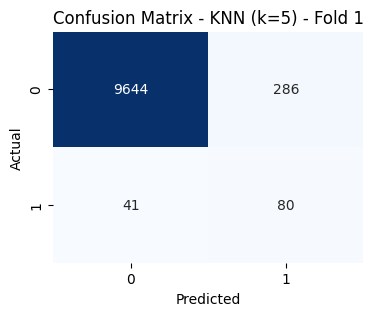


- Random Forest
Matrice de confusion :
 [[9840   90]
 [  44   77]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9930
           1       0.46      0.64      0.53       121

    accuracy                           0.99     10051
   macro avg       0.73      0.81      0.76     10051
weighted avg       0.99      0.99      0.99     10051



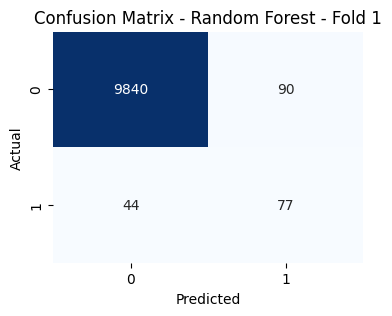


- Logistic Regression
Matrice de confusion :
 [[7006 2924]
 [  49   72]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.71      0.82      9930
           1       0.02      0.60      0.05       121

    accuracy                           0.70     10051
   macro avg       0.51      0.65      0.44     10051
weighted avg       0.98      0.70      0.82     10051



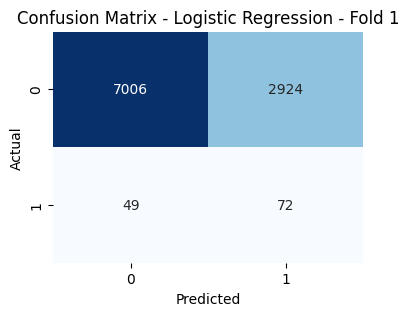


- XGBoost
Matrice de confusion :
 [[9723  207]
 [  38   83]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9930
           1       0.29      0.69      0.40       121

    accuracy                           0.98     10051
   macro avg       0.64      0.83      0.70     10051
weighted avg       0.99      0.98      0.98     10051



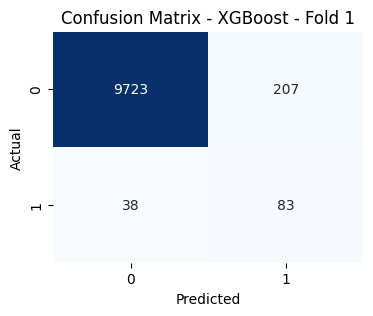


=== Fold 2 ===

- KNN (k=5)
Matrice de confusion :
 [[9693  237]
 [  41   80]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9930
           1       0.25      0.66      0.37       121

    accuracy                           0.97     10051
   macro avg       0.62      0.82      0.68     10051
weighted avg       0.99      0.97      0.98     10051



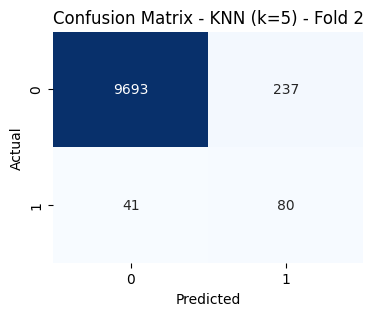


- Random Forest
Matrice de confusion :
 [[9876   54]
 [  47   74]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9930
           1       0.58      0.61      0.59       121

    accuracy                           0.99     10051
   macro avg       0.79      0.80      0.79     10051
weighted avg       0.99      0.99      0.99     10051



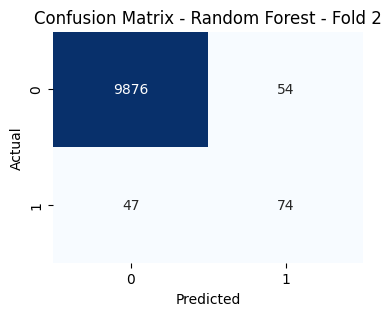


- Logistic Regression
Matrice de confusion :
 [[7064 2866]
 [  45   76]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.71      0.83      9930
           1       0.03      0.63      0.05       121

    accuracy                           0.71     10051
   macro avg       0.51      0.67      0.44     10051
weighted avg       0.98      0.71      0.82     10051



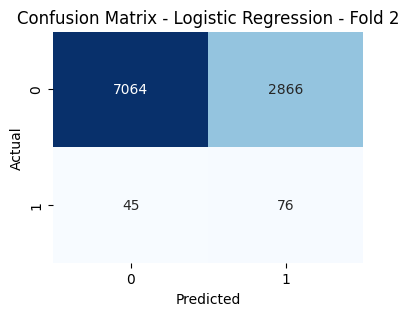


- XGBoost
Matrice de confusion :
 [[9773  157]
 [  45   76]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9930
           1       0.33      0.63      0.43       121

    accuracy                           0.98     10051
   macro avg       0.66      0.81      0.71     10051
weighted avg       0.99      0.98      0.98     10051



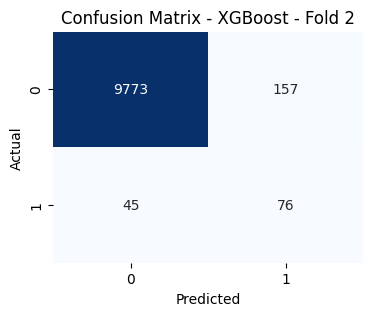


=== Fold 3 ===

- KNN (k=5)
Matrice de confusion :
 [[9687  242]
 [  44   78]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9929
           1       0.24      0.64      0.35       122

    accuracy                           0.97     10051
   macro avg       0.62      0.81      0.67     10051
weighted avg       0.99      0.97      0.98     10051



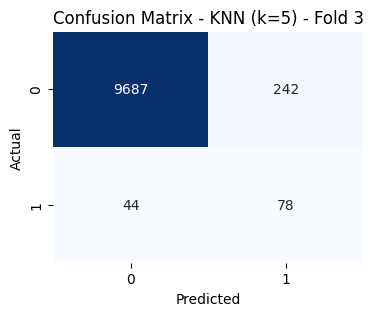


- Random Forest
Matrice de confusion :
 [[9854   75]
 [  45   77]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9929
           1       0.51      0.63      0.56       122

    accuracy                           0.99     10051
   macro avg       0.75      0.81      0.78     10051
weighted avg       0.99      0.99      0.99     10051



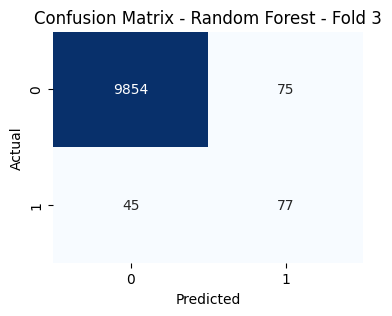


- Logistic Regression
Matrice de confusion :
 [[6977 2952]
 [  44   78]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.70      0.82      9929
           1       0.03      0.64      0.05       122

    accuracy                           0.70     10051
   macro avg       0.51      0.67      0.44     10051
weighted avg       0.98      0.70      0.81     10051



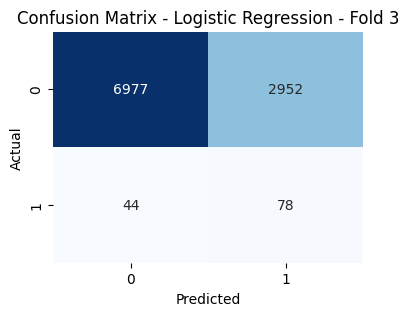


- XGBoost
Matrice de confusion :
 [[9747  182]
 [  41   81]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9929
           1       0.31      0.66      0.42       122

    accuracy                           0.98     10051
   macro avg       0.65      0.82      0.70     10051
weighted avg       0.99      0.98      0.98     10051



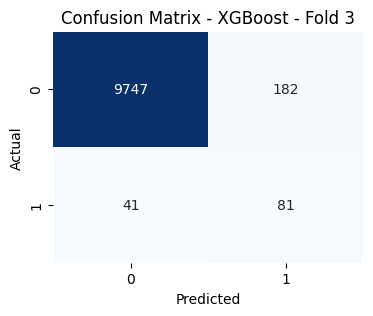


=== Fold 4 ===

- KNN (k=5)
Matrice de confusion :
 [[9665  264]
 [  36   85]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      9929
           1       0.24      0.70      0.36       121

    accuracy                           0.97     10050
   macro avg       0.62      0.84      0.67     10050
weighted avg       0.99      0.97      0.98     10050



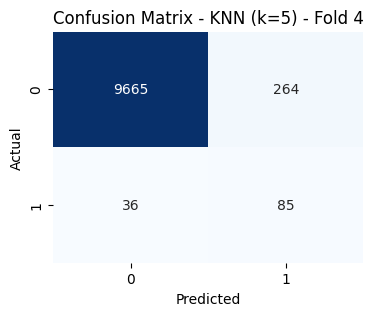


- Random Forest
Matrice de confusion :
 [[9859   70]
 [  40   81]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9929
           1       0.54      0.67      0.60       121

    accuracy                           0.99     10050
   macro avg       0.77      0.83      0.80     10050
weighted avg       0.99      0.99      0.99     10050



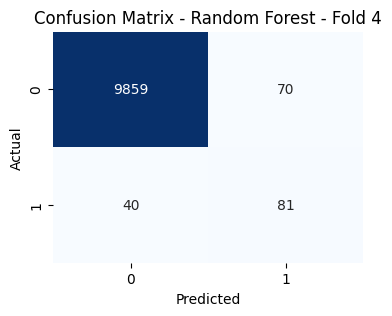


- Logistic Regression
Matrice de confusion :
 [[7013 2916]
 [  42   79]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.71      0.83      9929
           1       0.03      0.65      0.05       121

    accuracy                           0.71     10050
   macro avg       0.51      0.68      0.44     10050
weighted avg       0.98      0.71      0.82     10050



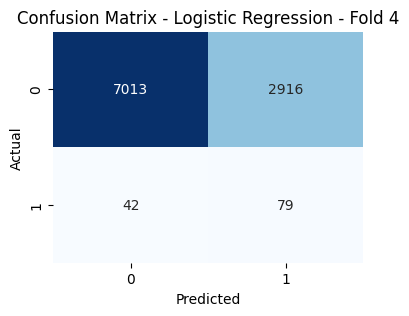


- XGBoost
Matrice de confusion :
 [[9731  198]
 [  35   86]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9929
           1       0.30      0.71      0.42       121

    accuracy                           0.98     10050
   macro avg       0.65      0.85      0.71     10050
weighted avg       0.99      0.98      0.98     10050



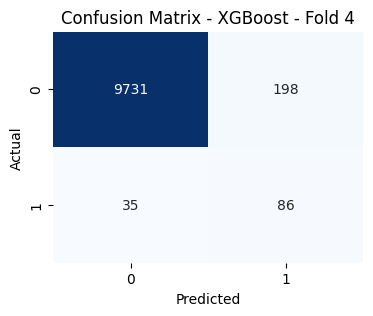


=== Fold 5 ===

- KNN (k=5)
Matrice de confusion :
 [[9673  256]
 [  51   70]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      9929
           1       0.21      0.58      0.31       121

    accuracy                           0.97     10050
   macro avg       0.60      0.78      0.65     10050
weighted avg       0.99      0.97      0.98     10050



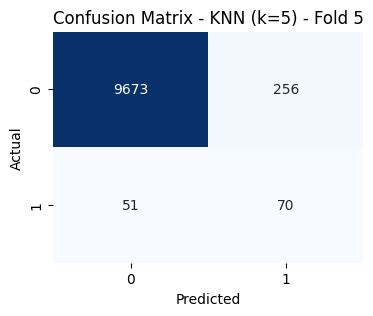


- Random Forest
Matrice de confusion :
 [[9874   55]
 [  57   64]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      9929
           1       0.54      0.53      0.53       121

    accuracy                           0.99     10050
   macro avg       0.77      0.76      0.76     10050
weighted avg       0.99      0.99      0.99     10050



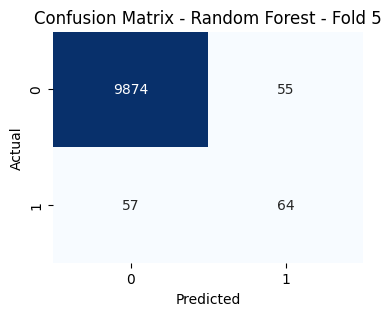


- Logistic Regression
Matrice de confusion :
 [[6803 3126]
 [  38   83]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.69      0.81      9929
           1       0.03      0.69      0.05       121

    accuracy                           0.69     10050
   macro avg       0.51      0.69      0.43     10050
weighted avg       0.98      0.69      0.80     10050



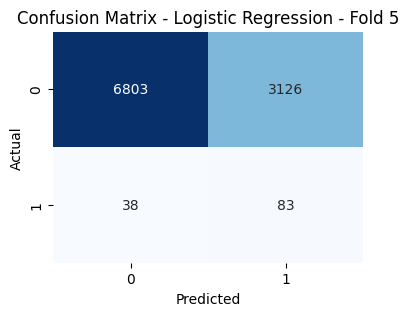


- XGBoost
Matrice de confusion :
 [[9780  149]
 [  48   73]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9929
           1       0.33      0.60      0.43       121

    accuracy                           0.98     10050
   macro avg       0.66      0.79      0.71     10050
weighted avg       0.99      0.98      0.98     10050



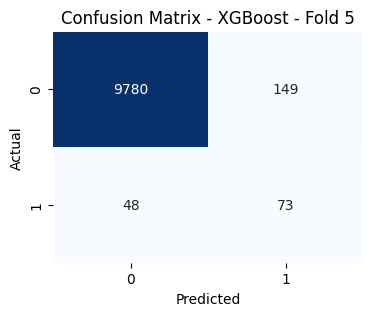


=== Résultats Moyens sur les 5 Folds ===

KNN (k=5):
 - Accuracy moyenne       = 0.9702
 - F1-score moyen         = 0.6645
 - ROC AUC moyen          = 0.8421
 - Average Precision mean = 0.3245

Random Forest:
 - Accuracy moyenne       = 0.9885
 - F1-score moyen         = 0.7791
 - ROC AUC moyen          = 0.8720
 - Average Precision mean = 0.5139

Logistic Regression:
 - Accuracy moyenne       = 0.7015
 - F1-score moyen         = 0.4360
 - ROC AUC moyen          = 0.7136
 - Average Precision mean = 0.0324

XGBoost:
 - Accuracy moyenne       = 0.9781
 - F1-score moyen         = 0.7049
 - ROC AUC moyen          = 0.8754
 - Average Precision mean = 0.6206


In [9]:
#KFold et Entrainement :

# Sélectionner les variables explicatives (X) et la cible (y)
X = df1[['NBRE', 'MCR', 'MDB', 'VALEUR', 'MNT', 'AGE', 'PROVISIONNE', 'le_PROFESSION', 'le_LIBCCL']]
y = df1['SORT']

# Fonction pour visualiser la matrice de confusion
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Models to evaluate
models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Results storage
results = {name: {"accuracy": [], "f1": [], "roc_auc": [], "avg_precision": []} for name in models}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        roc_auc = roc_auc_score(y_test, y_proba)
        avg_prec = average_precision_score(y_test, y_proba)

        # Store
        results[name]["accuracy"].append(acc)
        results[name]["f1"].append(f1)
        results[name]["roc_auc"].append(roc_auc)
        results[name]["avg_precision"].append(avg_prec)

        # Output
        print(f"\n- {name}")
        print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
        print("Rapport de classification :\n", classification_report(y_test, y_pred))

        # Plot
        plot_conf_matrix(confusion_matrix(y_test, y_pred), f"{name} - Fold {fold}")

# === Résumé des performances ===
print("\n=== Résultats Moyens sur les 5 Folds ===")
for name, scores in results.items():

    print(f"\n{name}:")
    print(f" - Accuracy moyenne       = {np.mean(scores['accuracy']):.4f}")
    print(f" - F1-score moyen         = {np.mean(scores['f1']):.4f}")
    print(f" - ROC AUC moyen          = {np.mean(scores['roc_auc']):.4f}")
    print(f" - Average Precision mean = {np.mean(scores['avg_precision']):.4f}")




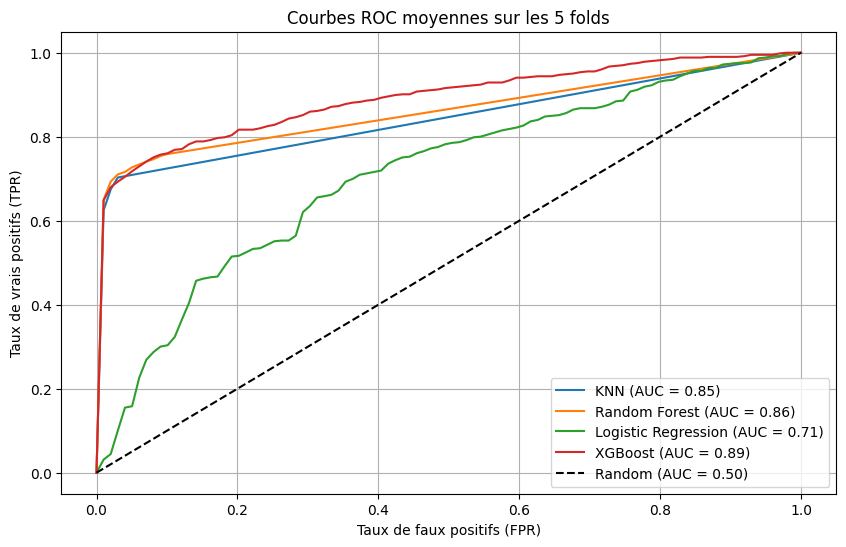

CONCLUSION
The best model based on F1-score is: Random Forest
With average metrics:
 - Accuracy: 0.9885
 - F1-score: 0.7791
 - ROC AUC: 0.8720
 - Average Precision: 0.5139


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize containers for ROC metrics
fpr_dict = {"KNN": [], "Random Forest": [], "Logistic Regression": [], "XGBoost": []}
tpr_dict = {"KNN": [], "Random Forest": [], "Logistic Regression": [], "XGBoost": []}
auc_dict = {"KNN": [], "Random Forest": [], "Logistic Regression": [], "XGBoost": []}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Models
    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    for name, model in models.items():
        model.fit(X_train_fold, y_train_fold)
        y_scores = model.predict_proba(X_test_fold)[:, 1]  # Probabilities for ROC
        fpr, tpr, _ = roc_curve(y_test_fold, y_scores)
        auc_score = auc(fpr, tpr)

        fpr_dict[name].append(fpr)
        tpr_dict[name].append(tpr)
        auc_dict[name].append(auc_score)

# Plot mean ROC curves
plt.figure(figsize=(10, 6))

for name in models.keys():
    # Interpolate all ROC curves to a common FPR axis
    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []

    for i in range(len(fpr_dict[name])):
        tpr_interp = np.interp(mean_fpr, fpr_dict[name][i], tpr_dict[name][i])
        tpr_interp[0] = 0.0
        tprs_interp.append(tpr_interp)

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_dict[name])

    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC moyennes sur les 5 folds")
plt.legend(loc="lower right")
plt.grid()
plt.show()



# CONCLUSION
print("CONCLUSION")
best_model = max(results, key=lambda x: np.nanmean(results[x]["f1"]))
print(f"The best model based on F1-score is: {best_model}")
print(f"With average metrics:")
print(f" - Accuracy: {np.nanmean(results[best_model]['accuracy']):.4f}")
print(f" - F1-score: {np.nanmean(results[best_model]['f1']):.4f}")
print(f" - ROC AUC: {np.nanmean(results[best_model]['roc_auc']):.4f}")
print(f" - Average Precision: {np.nanmean(results[best_model]['avg_precision']):.4f}")

In [11]:
# Tableau de comparaison

# Créer un tableau récapitulatif final
summary_table = []

for name, scores in results.items():
    summary_table.append({
        "Modèle": name,
        "Accuracy": np.mean(scores["accuracy"]),
        "Precision": np.mean(scores["avg_precision"]),
        "Recall": np.mean(scores["roc_auc"]),
        "F1-score": np.mean(scores["f1"]),
    })

# Convertir en DataFrame
summary_df1 = pd.DataFrame(summary_table)

# Afficher le tableau
print(summary_df1)

# Affichage formaté (optionnel, pour console ou rapport)
#import tabulate
#print(tabulate.tabulate(summary_df1, headers='keys', tablefmt='github', showindex=True))


                Modèle  Accuracy  Precision    Recall  F1-score
0            KNN (k=5)  0.970191   0.324492  0.842120  0.664542
1        Random Forest  0.988518   0.513910  0.872036  0.779098
2  Logistic Regression  0.701470   0.032420  0.713591  0.436040
3              XGBoost  0.978111   0.620629  0.875404  0.704862


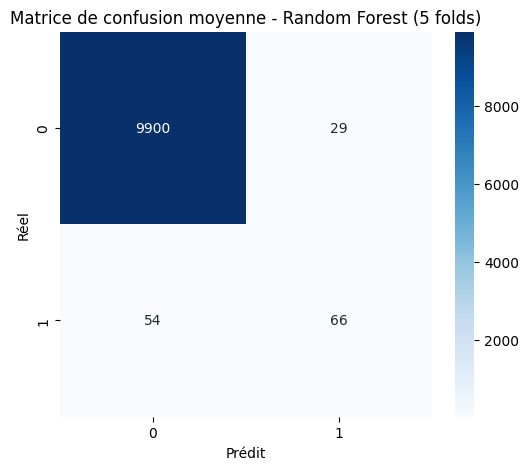

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For storing confusion matrices
conf_matrices_rf = []

# Re-run Stratified K-Fold for RF confusion matrices
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf.predict(X_test_fold)

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    conf_matrices_rf.append(cm)

# Compute mean confusion matrix
mean_cm_rf = np.mean(conf_matrices_rf, axis=0).astype(int)

# Display
plt.figure(figsize=(6, 5))
sns.heatmap(mean_cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion moyenne - Random Forest (5 folds)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

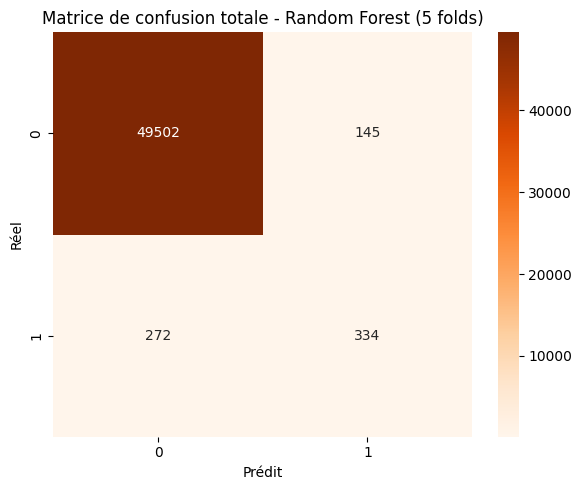

In [13]:
# Compute total confusion matrix
total_cm_rf = np.sum(conf_matrices_rf, axis=0)

# Display total confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(total_cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion totale - Random Forest (5 folds)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

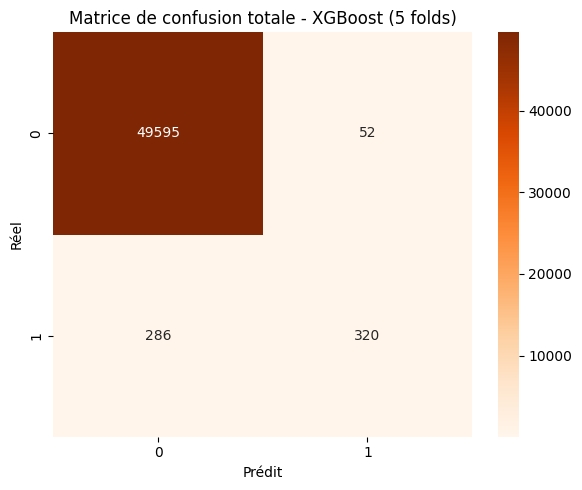

In [14]:
from xgboost import XGBClassifier

# For storing confusion matrices
conf_matrices_xgb = []

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = xgb.predict(X_test_fold)

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    conf_matrices_xgb.append(cm)

# Compute total confusion matrix
total_cm_xgb = np.sum(conf_matrices_xgb, axis=0)

# Display total confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(total_cm_xgb, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion totale - XGBoost (5 folds)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


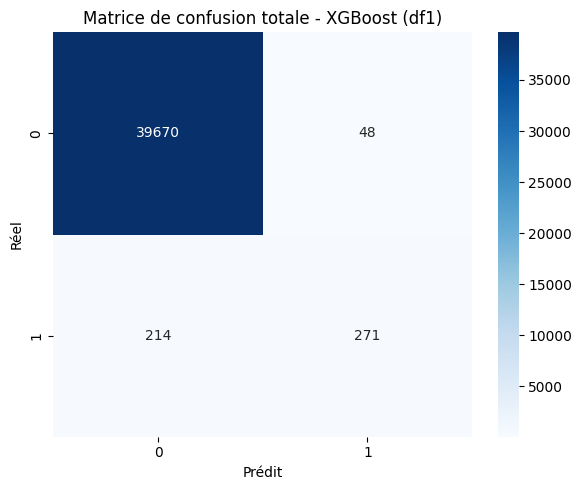


Rapport de classification total - XGBoost (df1):

              precision    recall  f1-score   support

           0     0.9946    0.9988    0.9967     39718
           1     0.8495    0.5588    0.6741       485

    accuracy                         0.9935     40203
   macro avg     0.9221    0.7788    0.8354     40203
weighted avg     0.9929    0.9935    0.9928     40203



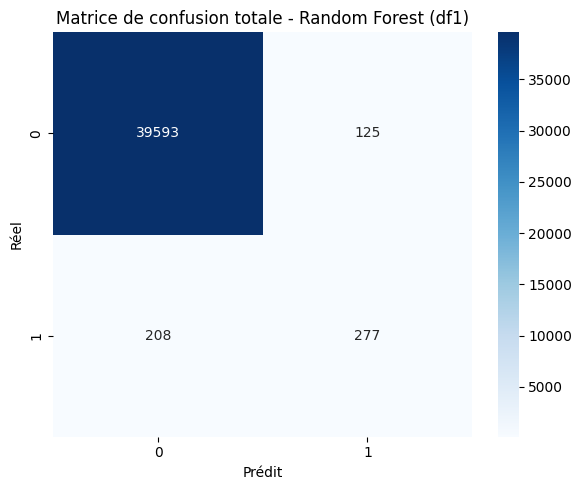


Rapport de classification total - Random Forest (df1):

              precision    recall  f1-score   support

           0     0.9948    0.9969    0.9958     39718
           1     0.6891    0.5711    0.6246       485

    accuracy                         0.9917     40203
   macro avg     0.8419    0.7840    0.8102     40203
weighted avg     0.9911    0.9917    0.9913     40203



In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def run_cv_and_report(model, X, y, model_name="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    total_cm = np.array([[0, 0], [0, 0]])
    y_true_all = []
    y_pred_all = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        # Append predictions for global report
        y_true_all.extend(y_test_fold)
        y_pred_all.extend(y_pred_fold)

        # Update total confusion matrix
        total_cm += confusion_matrix(y_test_fold, y_pred_fold)

    # Display total confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matrice de confusion totale - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nRapport de classification total - {model_name}:\n")
    print(classification_report(y_true_all, y_pred_all, digits=4))



# Run for XGBoost on df1
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
run_cv_and_report(xgb_model, X_train_fold, y_train_fold, model_name="XGBoost (df1)")

# Run for Random Forest on df2
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
run_cv_and_report(rf_model, X_train_fold, y_train_fold, model_name="Random Forest (df1)")

In [16]:
## DF2

In [17]:
# Vérifier les premières lignes
df2.head()

# Vérifier les informations sur le dataset
df2.info()

# Vérifier les statistiques descriptives
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8927 entries, 0 to 8926
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   NBRE        8864 non-null   float64       
 1   MCR         8864 non-null   float64       
 2   MDB         8864 non-null   float64       
 3   VALEUR      8927 non-null   int64         
 4   DATECPS     8927 non-null   datetime64[ns]
 5   NUM         0 non-null      float64       
 6   MNT         8925 non-null   float64       
 7   ID          8901 non-null   float64       
 8   DNA         8540 non-null   datetime64[ns]
 9   PROFESSION  8195 non-null   object        
 10  LIBCCL      8858 non-null   object        
 11  SORT        8927 non-null   object        
dtypes: datetime64[ns](2), float64(6), int64(1), object(3)
memory usage: 837.0+ KB


,NBRE,MCR,MDB,VALEUR,DATECPS,NUM,MNT,ID,DNA
count,8864.000000,8.864000e+03,8.864000e+03,8927.000000,8927,0.0,8925.000000,8.901000e+03,8540
mean,43.807310,4.827420e+04,4.738282e+04,40.996863,2025-01-09 08:47:38.384675840,NaN,1569.842667,8.754051e+10,1979-04-19 18:56:21.217798656
min,1.000000,0.000000e+00,0.000000e+00,40.000000,2024-10-01 00:00:00,NaN,24.500000,3.690000e+02,1900-06-20 00:00:00
25%,19.000000,5.423027e+03,5.247775e+03,41.000000,2024-12-02 00:00:00,NaN,90.700000,1.858184e+06,1970-11-18 00:00:00
50%,27.000000,9.717702e+03,8.963404e+03,41.000000,2025-01-16 00:00:00,NaN,143.430000,3.922730e+06,1980-11-02 00:00:00
75%,47.000000,1.282768e+04,1.309075e+04,41.000000,2025-02-28 00:00:00,NaN,500.000000,5.833789e+06,1987-07-06 12:00:00
max,1057.000000,4.486243e+06,4.458645e+06,41.000000,2025-03-28 00:00:00,NaN,75000.000000,1.881328e+13,2004-11-16 00:00:00
std,77.377669,3.178323e+05,3.150377e+05,0.055920,NaN,NaN,4883.869200,1.274948e+12,NaN


In [18]:
 # 1. DATA EXPLORATION
print("# 1. DATA EXPLORATION")
print("\n# Vérifier les premières lignes")
print(df2.head())

print("\n# Vérifier les informations sur le dataset")
print(df2.info())

print("\n# Vérifier les statistiques descriptives")
print(df2.describe())


# 1. DATA EXPLORATION

# Vérifier les premières lignes
   NBRE        MCR       MDB  VALEUR    DATECPS  NUM      MNT         ID  \
0  21.0   6160.260   6127.00      41 2024-10-01  NaN  152.110  6350778.0   
1  31.0   5325.396   5256.26      41 2024-10-01  NaN  112.565  6445711.0   
2  20.0   5899.729   5878.28      41 2024-10-01  NaN   61.880  6851305.0   
3  27.0  10731.612  10663.32      41 2024-10-01  NaN  133.385  1362154.0   
4   2.0      0.000      6.00      41 2024-10-01  NaN   90.700  1477221.0   

         DNA        PROFESSION             LIBCCL SORT  
0 1973-04-15               NaN  Personne physique    R  
1 1978-09-15  AUTRE PROFESSION  Personne physique    P  
2 1974-02-01  AUTRE PROFESSION  Personne physique    P  
3 1977-06-08  AUTRE PROFESSION  Personne physique    R  
4 1969-01-28  AUTRE PROFESSION  Personne physique    R  

# Vérifier les informations sur le dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8927 entries, 0 to 8926
Data columns (total 12 colum

In [40]:
print(df2)

      NBRE         MCR         MDB  VALEUR    DATECPS       MNT         ID  \
0     21.0    6160.260    6127.000      41 2024-10-01   152.110  6350778.0   
1     31.0    5325.396    5256.260      41 2024-10-01   112.565  6445711.0   
2     20.0    5899.729    5878.280      41 2024-10-01    61.880  6851305.0   
3     27.0   10731.612   10663.320      41 2024-10-01   133.385  1362154.0   
4      2.0       0.000       6.000      41 2024-10-01    90.700  1477221.0   
...    ...         ...         ...     ...        ...       ...        ...   
8921  20.0    6564.035    6602.760      41 2025-03-28   101.460  5833789.0   
8922  33.0    5035.416    5036.999      41 2025-03-28    76.499  6032639.0   
8923  40.0    8556.588    8948.905      41 2025-03-28    54.260  6060142.0   
8924  76.0   10255.503   10685.998      41 2025-03-28    51.620  6101753.0   
8926  54.0  137447.000  135713.576      41 2025-03-28  3401.000  1825071.0   

            DNA                                     PROFESSION 

In [41]:
df2.isna().sum()

,0
NBRE,0
MCR,0
MDB,0
VALEUR,0
DATECPS,0
MNT,0
ID,0
DNA,318
PROFESSION,0
LIBCCL,0


In [43]:
#Prétraitement des données



# Suppression de la colonne 'NUM'
df2 = df2.drop('NUM', axis=1)


#suppression des lignes NAN pour la colonne LIBCCL
df2 = df2.dropna(subset=["LIBCCL"])

# Remplacer NaN dans la colonne PROFESSION par AUTRE PROFESSION
df2['PROFESSION'] = df2['PROFESSION'].fillna('AUTRE PROFESSION')


# Conversion en float
for col in ['MCR', 'MDB', 'MNT']:
    df2[col] = df2[col].astype(str).str.replace(' ', '').str.replace(',', '.')
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Calculer l'âge à partir de la date de naissance (DNA)
df2['DNA'] = pd.to_datetime(df2['DNA'], errors='coerce')
df2['AGE'] = (pd.Timestamp.today() - df2['DNA']).dt.days // 365

# Encodage des variables catégorielles (PROFESSION, LIBCCL)
le_profession = LabelEncoder()  # Création de l'encodeur
df2['le_PROFESSION'] = le_profession.fit_transform(df2['PROFESSION'].fillna(''))

le_libccl = LabelEncoder()  # Création de l'encodeur pour LIBCCL
df2['le_LIBCCL'] = le_libccl.fit_transform(df2['LIBCCL'].fillna(''))

# Encoder la variable cible 'SORT'
df2['SORT'] = df2['SORT'].map({'P': 0, 'R': 1})

#**************************




# Calcul de l'asymétrie pour les colonnes numériques

colonnes_numeriques = df2.select_dtypes(include=['number']).columns
valeurs_asymetrie = df2[colonnes_numeriques].skew()

# Imputation des valeurs manquantes en fonction de l'asymétrie

# Définir les colonnes à imputer avec la médiane (forte asymétrie) ou la moyenne (asymétrie faible)
colonnes_median = ['NBRE', 'MCR', 'MDB', 'MNT', 'le_PROFESSION', 'le_LIBCCL']
colonnes_moyenne = ['AGE']

# Imputation avec la médiane pour les colonnes asymétriques
for col in colonnes_median:
    if col in df2.columns:
        df2[col] = df2[col].fillna(df2[col].median())
        print(f"{col}: Filled NaN with median (high skew)")

# Imputation avec la moyenne pour les colonnes à distribution relativement normale
for col in colonnes_moyenne:
    if col in df2.columns:
        df2[col] = df2[col].fillna(df2[col].mean())
        print(f"{col}: Filled NaN with mean (low skew)")


KeyError: "['NUM'] not found in axis"

In [22]:
df2.isna().sum()

,0
NBRE,0
MCR,0
MDB,0
VALEUR,0
DATECPS,0
MNT,0
ID,0
DNA,318
PROFESSION,0
LIBCCL,0


In [44]:
print(df2)

      NBRE         MCR         MDB  VALEUR    DATECPS       MNT         ID  \
0     21.0    6160.260    6127.000      41 2024-10-01   152.110  6350778.0   
1     31.0    5325.396    5256.260      41 2024-10-01   112.565  6445711.0   
2     20.0    5899.729    5878.280      41 2024-10-01    61.880  6851305.0   
3     27.0   10731.612   10663.320      41 2024-10-01   133.385  1362154.0   
4      2.0       0.000       6.000      41 2024-10-01    90.700  1477221.0   
...    ...         ...         ...     ...        ...       ...        ...   
8921  20.0    6564.035    6602.760      41 2025-03-28   101.460  5833789.0   
8922  33.0    5035.416    5036.999      41 2025-03-28    76.499  6032639.0   
8923  40.0    8556.588    8948.905      41 2025-03-28    54.260  6060142.0   
8924  76.0   10255.503   10685.998      41 2025-03-28    51.620  6101753.0   
8926  54.0  137447.000  135713.576      41 2025-03-28  3401.000  1825071.0   

            DNA                                     PROFESSION 


# 4. MODEL BUILDING AND EVALUATION

# Cross-validation results

=== Fold 1 ===

- KNN (k=5)
Matrice de confusion :
 [[1042  212]
 [ 136  382]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.83      0.86      1254
           1       0.64      0.74      0.69       518

    accuracy                           0.80      1772
   macro avg       0.76      0.78      0.77      1772
weighted avg       0.81      0.80      0.81      1772



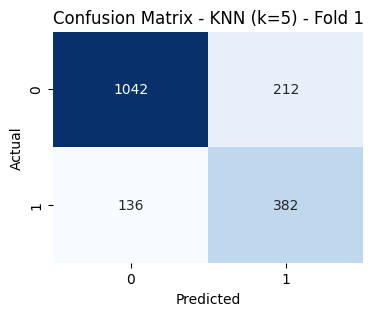


- Random Forest
Matrice de confusion :
 [[1124  130]
 [ 145  373]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1254
           1       0.74      0.72      0.73       518

    accuracy                           0.84      1772
   macro avg       0.81      0.81      0.81      1772
weighted avg       0.84      0.84      0.84      1772



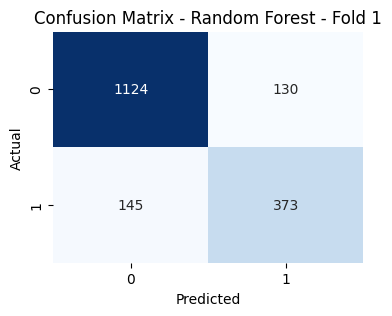


- Logistic Regression
Matrice de confusion :
 [[735 519]
 [145 373]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.59      0.69      1254
           1       0.42      0.72      0.53       518

    accuracy                           0.63      1772
   macro avg       0.63      0.65      0.61      1772
weighted avg       0.71      0.63      0.64      1772



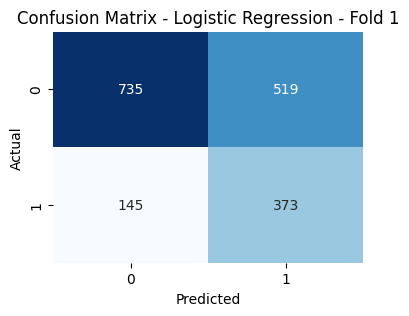


- XGBoost
Matrice de confusion :
 [[1134  120]
 [ 151  367]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1254
           1       0.75      0.71      0.73       518

    accuracy                           0.85      1772
   macro avg       0.82      0.81      0.81      1772
weighted avg       0.84      0.85      0.85      1772



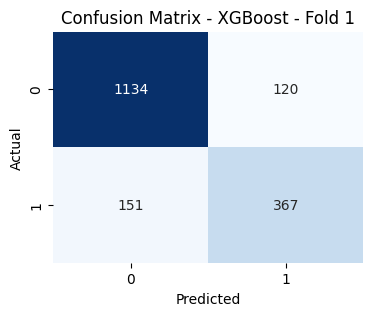


=== Fold 2 ===

- KNN (k=5)
Matrice de confusion :
 [[1031  223]
 [ 142  376]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1254
           1       0.63      0.73      0.67       518

    accuracy                           0.79      1772
   macro avg       0.75      0.77      0.76      1772
weighted avg       0.81      0.79      0.80      1772



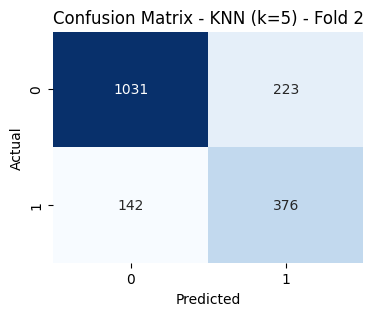


- Random Forest
Matrice de confusion :
 [[1112  142]
 [ 147  371]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1254
           1       0.72      0.72      0.72       518

    accuracy                           0.84      1772
   macro avg       0.80      0.80      0.80      1772
weighted avg       0.84      0.84      0.84      1772



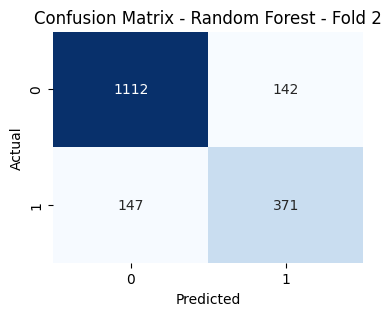


- Logistic Regression
Matrice de confusion :
 [[683 571]
 [134 384]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.54      0.66      1254
           1       0.40      0.74      0.52       518

    accuracy                           0.60      1772
   macro avg       0.62      0.64      0.59      1772
weighted avg       0.71      0.60      0.62      1772



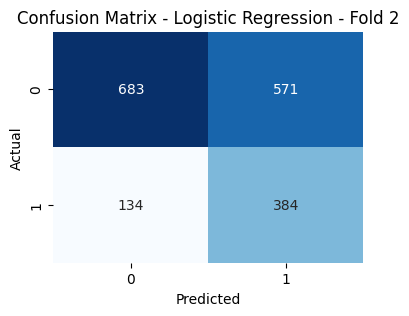


- XGBoost
Matrice de confusion :
 [[1099  155]
 [ 149  369]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1254
           1       0.70      0.71      0.71       518

    accuracy                           0.83      1772
   macro avg       0.79      0.79      0.79      1772
weighted avg       0.83      0.83      0.83      1772



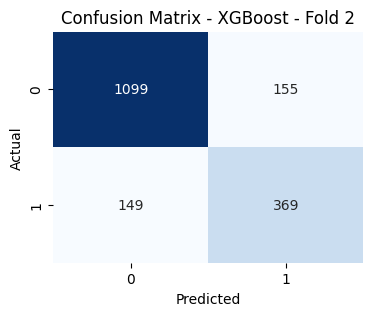


=== Fold 3 ===

- KNN (k=5)
Matrice de confusion :
 [[1078  176]
 [ 153  365]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1254
           1       0.67      0.70      0.69       518

    accuracy                           0.81      1772
   macro avg       0.78      0.78      0.78      1772
weighted avg       0.82      0.81      0.82      1772



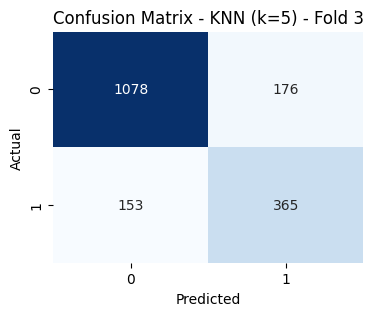


- Random Forest
Matrice de confusion :
 [[1135  119]
 [ 165  353]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1254
           1       0.75      0.68      0.71       518

    accuracy                           0.84      1772
   macro avg       0.81      0.79      0.80      1772
weighted avg       0.84      0.84      0.84      1772



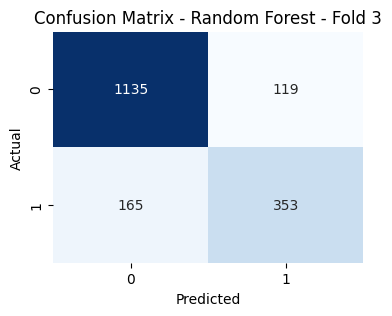


- Logistic Regression
Matrice de confusion :
 [[727 527]
 [154 364]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.58      0.68      1254
           1       0.41      0.70      0.52       518

    accuracy                           0.62      1772
   macro avg       0.62      0.64      0.60      1772
weighted avg       0.70      0.62      0.63      1772



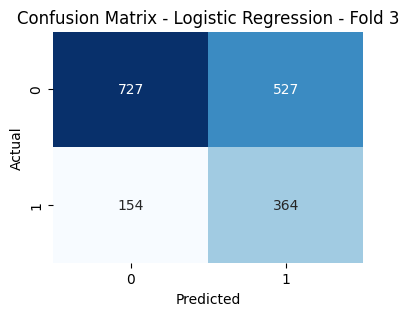


- XGBoost
Matrice de confusion :
 [[1142  112]
 [ 173  345]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1254
           1       0.75      0.67      0.71       518

    accuracy                           0.84      1772
   macro avg       0.81      0.79      0.80      1772
weighted avg       0.84      0.84      0.84      1772



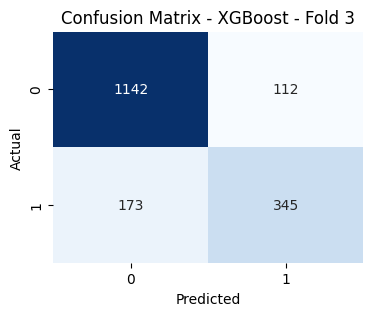


=== Fold 4 ===

- KNN (k=5)
Matrice de confusion :
 [[1017  236]
 [ 141  377]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1253
           1       0.62      0.73      0.67       518

    accuracy                           0.79      1771
   macro avg       0.75      0.77      0.76      1771
weighted avg       0.80      0.79      0.79      1771



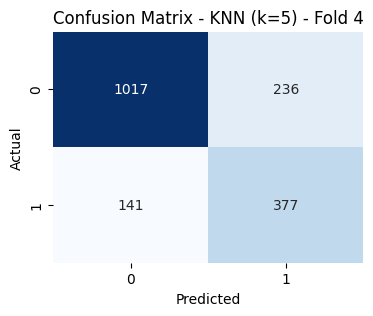


- Random Forest
Matrice de confusion :
 [[1112  141]
 [ 141  377]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1253
           1       0.73      0.73      0.73       518

    accuracy                           0.84      1771
   macro avg       0.81      0.81      0.81      1771
weighted avg       0.84      0.84      0.84      1771



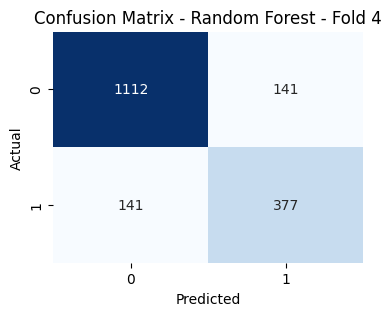


- Logistic Regression
Matrice de confusion :
 [[692 561]
 [139 379]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.55      0.66      1253
           1       0.40      0.73      0.52       518

    accuracy                           0.60      1771
   macro avg       0.62      0.64      0.59      1771
weighted avg       0.71      0.60      0.62      1771



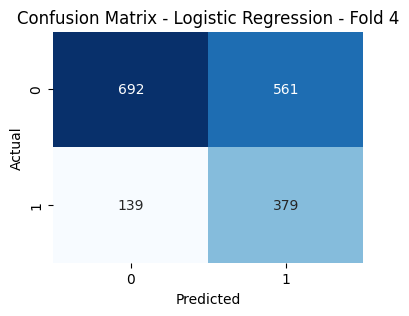


- XGBoost
Matrice de confusion :
 [[1099  154]
 [ 156  362]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1253
           1       0.70      0.70      0.70       518

    accuracy                           0.82      1771
   macro avg       0.79      0.79      0.79      1771
weighted avg       0.82      0.82      0.82      1771



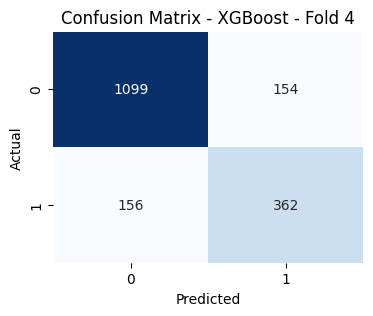


=== Fold 5 ===

- KNN (k=5)
Matrice de confusion :
 [[1054  199]
 [ 123  395]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      1253
           1       0.66      0.76      0.71       518

    accuracy                           0.82      1771
   macro avg       0.78      0.80      0.79      1771
weighted avg       0.83      0.82      0.82      1771



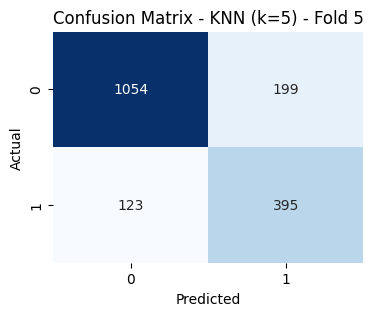


- Random Forest
Matrice de confusion :
 [[1138  115]
 [ 136  382]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1253
           1       0.77      0.74      0.75       518

    accuracy                           0.86      1771
   macro avg       0.83      0.82      0.83      1771
weighted avg       0.86      0.86      0.86      1771



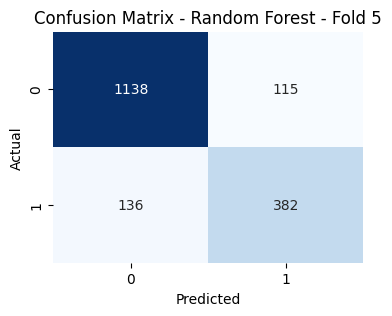


- Logistic Regression
Matrice de confusion :
 [[711 542]
 [149 369]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.57      0.67      1253
           1       0.41      0.71      0.52       518

    accuracy                           0.61      1771
   macro avg       0.62      0.64      0.59      1771
weighted avg       0.70      0.61      0.63      1771



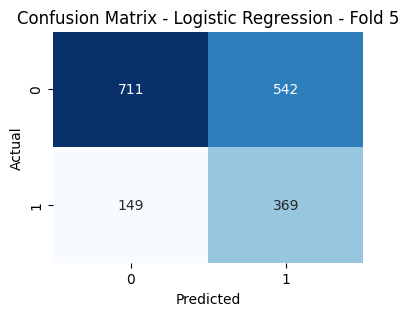


- XGBoost
Matrice de confusion :
 [[1128  125]
 [ 161  357]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1253
           1       0.74      0.69      0.71       518

    accuracy                           0.84      1771
   macro avg       0.81      0.79      0.80      1771
weighted avg       0.84      0.84      0.84      1771



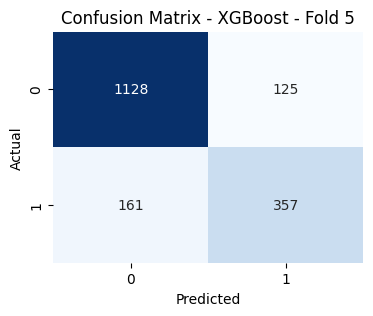


=== Résultats Moyens sur les 5 Folds ===

KNN (k=5):
 - Accuracy moyenne       = 0.8035
 - F1-score moyen         = 0.7712
 - ROC AUC moyen          = 0.8433
 - Average Precision mean = 0.7094

Random Forest:
 - Accuracy moyenne       = 0.8441
 - F1-score moyen         = 0.8097
 - ROC AUC moyen          = 0.8783
 - Average Precision mean = 0.8057

Logistic Regression:
 - Accuracy moyenne       = 0.6115
 - F1-score moyen         = 0.5970
 - ROC AUC moyen          = 0.7098
 - Average Precision mean = 0.5103

XGBoost:
 - Accuracy moyenne       = 0.8356
 - F1-score moyen         = 0.7985
 - ROC AUC moyen          = 0.8696
 - Average Precision mean = 0.8106


In [45]:
# KFold et Evaluation
# 4. MODEL BUILDING AND EVALUATION
print("\n# 4. MODEL BUILDING AND EVALUATION")

# Select features and target
X = df2[['NBRE', 'MCR', 'MDB', 'MNT', 'AGE', 'le_PROFESSION', 'le_LIBCCL']]
y = df2['SORT']

# Function to visualize confusion matrix
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Models to evaluate
models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Results storage
results = {name: {"accuracy": [], "f1": [], "roc_auc": [], "avg_precision": []} for name in models}

# Perform cross-validation
print("\n# Cross-validation results")
# We'll use 5-fold cross-validation like in the original code
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

        # For ROC and precision-recall curves, we need probabilities
        try:
            y_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1
        except:
            # Some models might not have predict_proba
            y_proba = y_pred

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")

        # Ensure there are both classes in the test set for ROC calculations
        if len(np.unique(y_test)) > 1:
            roc_auc = roc_auc_score(y_test, y_proba)
            avg_prec = average_precision_score(y_test, y_proba)
        else:
            roc_auc = np.nan
            avg_prec = np.nan

        # Store results
        results[name]["accuracy"].append(acc)
        results[name]["f1"].append(f1)
        results[name]["roc_auc"].append(roc_auc)
        results[name]["avg_precision"].append(avg_prec)

        # Output current results
        print(f"\n- {name}")
        print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
        print("Rapport de classification :\n", classification_report(y_test, y_pred))

        # Plot confusion matrix
        plot_conf_matrix(confusion_matrix(y_test, y_pred), f"{name} - Fold {fold}")

# Display summary of results
print("\n=== Résultats Moyens sur les 5 Folds ===")
for name, scores in results.items():
    print(f"\n{name}:")
    print(f" - Accuracy moyenne       = {np.nanmean(scores['accuracy']):.4f}")
    print(f" - F1-score moyen         = {np.nanmean(scores['f1']):.4f}")
    print(f" - ROC AUC moyen          = {np.nanmean(scores['roc_auc']):.4f}")
    print(f" - Average Precision mean = {np.nanmean(scores['avg_precision']):.4f}")

In [46]:
# Tableau de comparaison


# Créer un tableau récapitulatif final
summary_table = []

for name, scores in results.items():
    summary_table.append({
        "Modèle": name,
        "Accuracy": np.mean(scores["accuracy"]),
        "Precision": np.mean(scores["avg_precision"]),
        "Recall": np.mean(scores["roc_auc"]),
        "F1-score": np.mean(scores["f1"]),
    })

# Convertir en DataFrame
summary_df2 = pd.DataFrame(summary_table)

# Afficher le tableau
print(summary_df2)

                Modèle  Accuracy  Precision    Recall  F1-score
0            KNN (k=5)  0.803454   0.709440  0.843342  0.771196
1        Random Forest  0.844097   0.805658  0.878282  0.809693
2  Logistic Regression  0.611537   0.510277  0.709798  0.597002
3              XGBoost  0.835628   0.810559  0.869568  0.798520


ROC CURVE VISUALIZATION


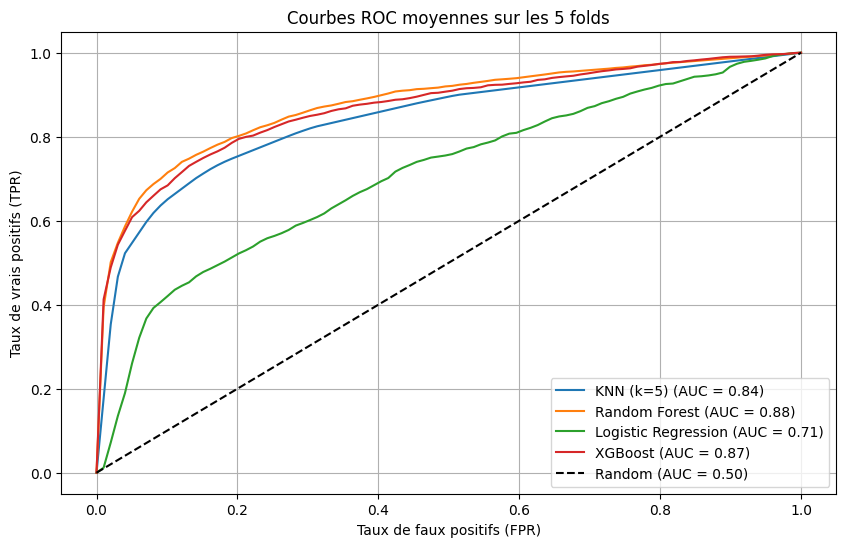

CONCLUSION
The best model based on F1-score is: Random Forest
With average metrics:
 - Accuracy: 0.8441
 - F1-score: 0.8097
 - ROC AUC: 0.8783
 - Average Precision: 0.8057


In [47]:
# ROC CURVE VISUALIZATION
print("ROC CURVE VISUALIZATION")

# Initialize containers for ROC metrics
fpr_dict = {name: [] for name in models.keys()}
tpr_dict = {name: [] for name in models.keys()}
auc_dict = {name: [] for name in models.keys()}

# Re-run cross-validation for ROC curve data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)

        # Get probabilities for class 1
        try:
            y_scores = model.predict_proba(X_test_fold)[:, 1]
        except:
            # Fallback for models without predict_proba
            y_scores = model.predict(X_test_fold)

        # Only calculate ROC if there are samples from both classes
        if len(np.unique(y_test_fold)) > 1:
            fpr, tpr, _ = roc_curve(y_test_fold, y_scores)
            auc_score = auc(fpr, tpr)

            fpr_dict[name].append(fpr)
            tpr_dict[name].append(tpr)
            auc_dict[name].append(auc_score)

# Plot mean ROC curves
plt.figure(figsize=(10, 6))

for name in models.keys():
    if not fpr_dict[name]:  # Skip if no data was collected
        print(f"No ROC data for {name}")
        continue

    # Interpolate all ROC curves to a common FPR axis
    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []

    for i in range(len(fpr_dict[name])):
        if len(fpr_dict[name][i]) < 2:  # Skip if not enough points for interpolation
            continue
        tpr_interp = np.interp(mean_fpr, fpr_dict[name][i], tpr_dict[name][i])
        tpr_interp[0] = 0.0
        tprs_interp.append(tpr_interp)

    if tprs_interp:  # Only plot if we have valid data
        mean_tpr = np.mean(tprs_interp, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.nanmean(auc_dict[name])

        plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Final plot settings
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC moyennes sur les 5 folds")
plt.legend(loc="lower right")
plt.grid()
plt.show()



# CONCLUSION
print("CONCLUSION")
best_model = max(results, key=lambda x: np.nanmean(results[x]["f1"]))
print(f"The best model based on F1-score is: {best_model}")
print(f"With average metrics:")
print(f" - Accuracy: {np.nanmean(results[best_model]['accuracy']):.4f}")
print(f" - F1-score: {np.nanmean(results[best_model]['f1']):.4f}")
print(f" - ROC AUC: {np.nanmean(results[best_model]['roc_auc']):.4f}")
print(f" - Average Precision: {np.nanmean(results[best_model]['avg_precision']):.4f}")

Fold 1 Confusion Matrix:
[[1154  100]
 [ 167  351]]



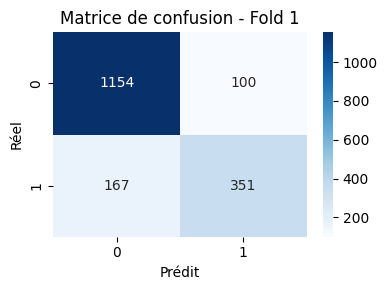

Fold 2 Confusion Matrix:
[[1130  124]
 [ 159  359]]



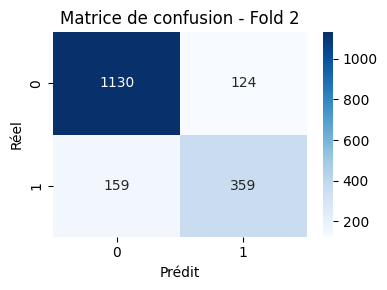

Fold 3 Confusion Matrix:
[[1164   90]
 [ 183  335]]



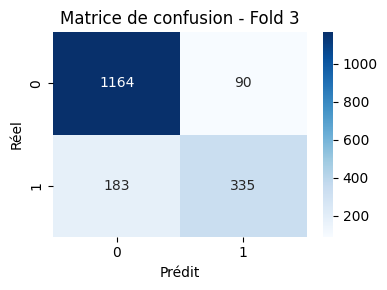

Fold 4 Confusion Matrix:
[[1144  109]
 [ 158  360]]



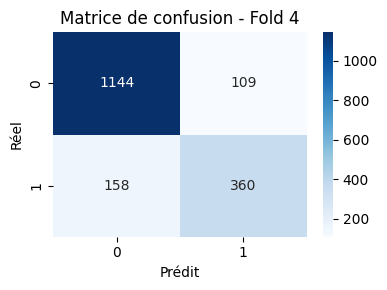

Fold 5 Confusion Matrix:
[[1168   85]
 [ 149  369]]



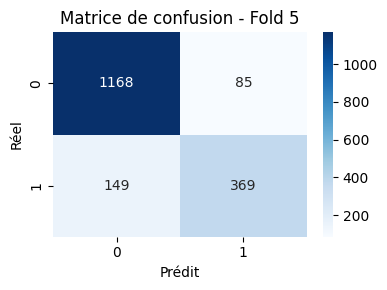

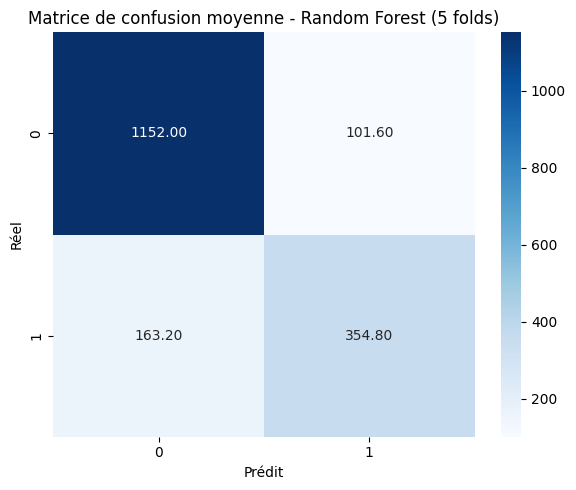

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For storing confusion matrices
conf_matrices_rf = []

# Re-run Stratified K-Fold for RF confusion matrices
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf.predict(X_test_fold)

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    conf_matrices_rf.append(cm)

    # Print and display each confusion matrix
    print(f"Fold {i+1} Confusion Matrix:\n{cm}\n")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matrice de confusion - Fold {i+1}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

# Compute mean confusion matrix
mean_cm_rf = np.mean(conf_matrices_rf, axis=0)

# Display mean confusion matrix (with float values)
plt.figure(figsize=(6, 5))
sns.heatmap(mean_cm_rf, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion moyenne - Random Forest (5 folds)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

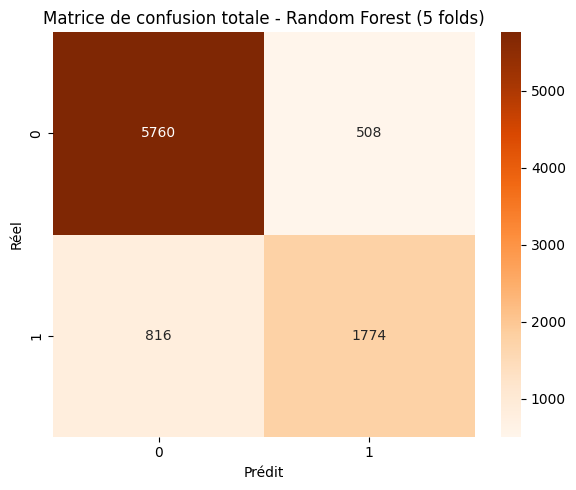

In [28]:
# Compute total confusion matrix
total_cm_rf = np.sum(conf_matrices_rf, axis=0)

# Display total confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(total_cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion totale - Random Forest (5 folds)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

Fold 1 Confusion Matrix:
[[1154  100]
 [ 167  351]]



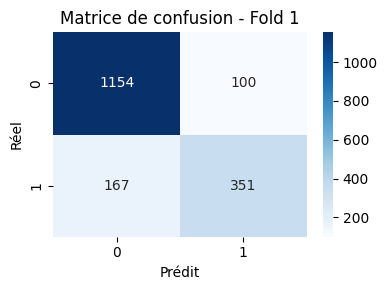

Fold 2 Confusion Matrix:
[[1130  124]
 [ 159  359]]



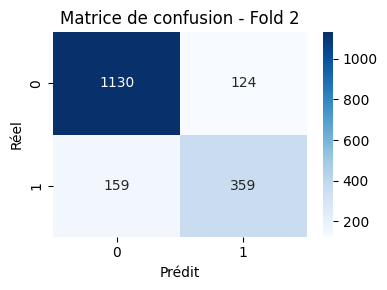

Fold 3 Confusion Matrix:
[[1164   90]
 [ 183  335]]



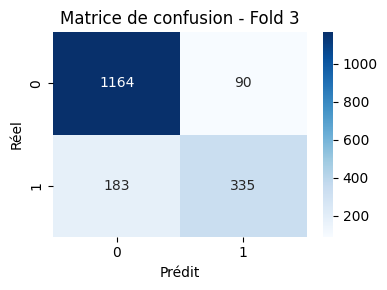

Fold 4 Confusion Matrix:
[[1144  109]
 [ 158  360]]



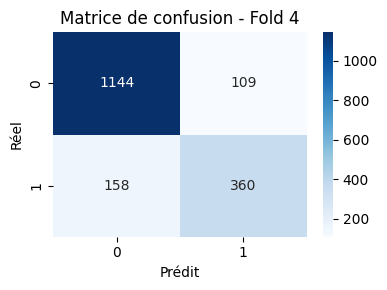

Fold 5 Confusion Matrix:
[[1168   85]
 [ 149  369]]



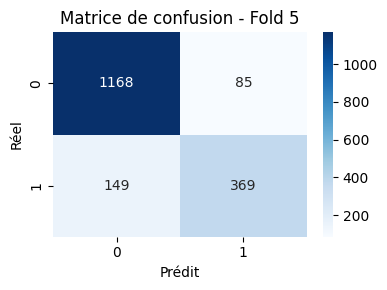

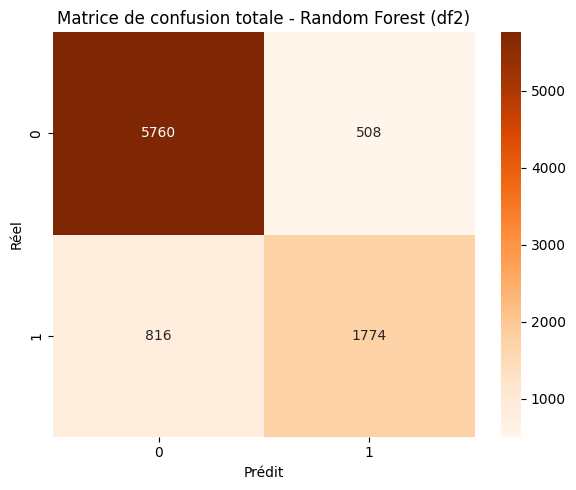

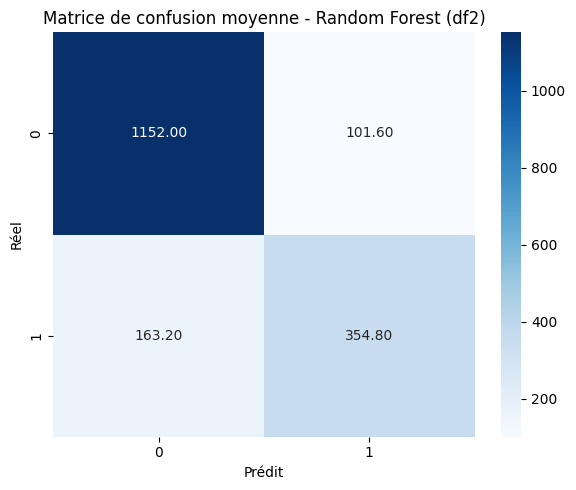


Rapport de classification total - Random Forest (df2):

              precision    recall  f1-score   support

           0     0.8759    0.9190    0.8969      6268
           1     0.7774    0.6849    0.7282      2590

    accuracy                         0.8505      8858
   macro avg     0.8267    0.8019    0.8126      8858
weighted avg     0.8471    0.8505    0.8476      8858



In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



conf_matrices_rf = []
y_true_all = []
y_pred_all = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf.predict(X_test_fold)

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    conf_matrices_rf.append(cm)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

    # Print and plot confusion matrix per fold
    print(f"Fold {i+1} Confusion Matrix:\n{cm}\n")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matrice de confusion - Fold {i+1}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

# --- Total Confusion Matrix ---
total_cm_rf = np.sum(conf_matrices_rf, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(total_cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion totale - Random Forest (df2)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# --- Mean Confusion Matrix ---
mean_cm_rf = np.mean(conf_matrices_rf, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(mean_cm_rf, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de confusion moyenne - Random Forest (df2)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# --- Classification Report ---
print("\nRapport de classification total - Random Forest (df2):\n")
print(classification_report(y_true_all, y_pred_all, digits=4))


In [30]:
# Convertir 'DATECPS' en datetime et extraire l'année/mois
df1['DATECPS'] = pd.to_datetime(df1['DATECPS'])
df1['ANNEE'] = df1['DATECPS'].dt.year
df1['MOIS'] = df1['DATECPS'].dt.month

# Filtrer les données avant/après la loi (ex: loi appliquée en 2024)
date_loi = '2025-02-01'
df1_avant = df1[df1['DATECPS'] < date_loi]
df1_apres = df1[df1['DATECPS'] >= date_loi]

# Calculer le taux de rejet global avant/après
taux1_avant = df1_avant['SORT'].mean() * 100
taux1_apres = df1_apres['SORT'].mean() * 100

print(f"Taux de rejet avant la loi : {taux1_avant:.2f}%")
print(f"Taux de rejet après la loi : {taux1_apres:.2f}%")

Taux de rejet avant la loi : 1.26%
Taux de rejet après la loi : 0.78%


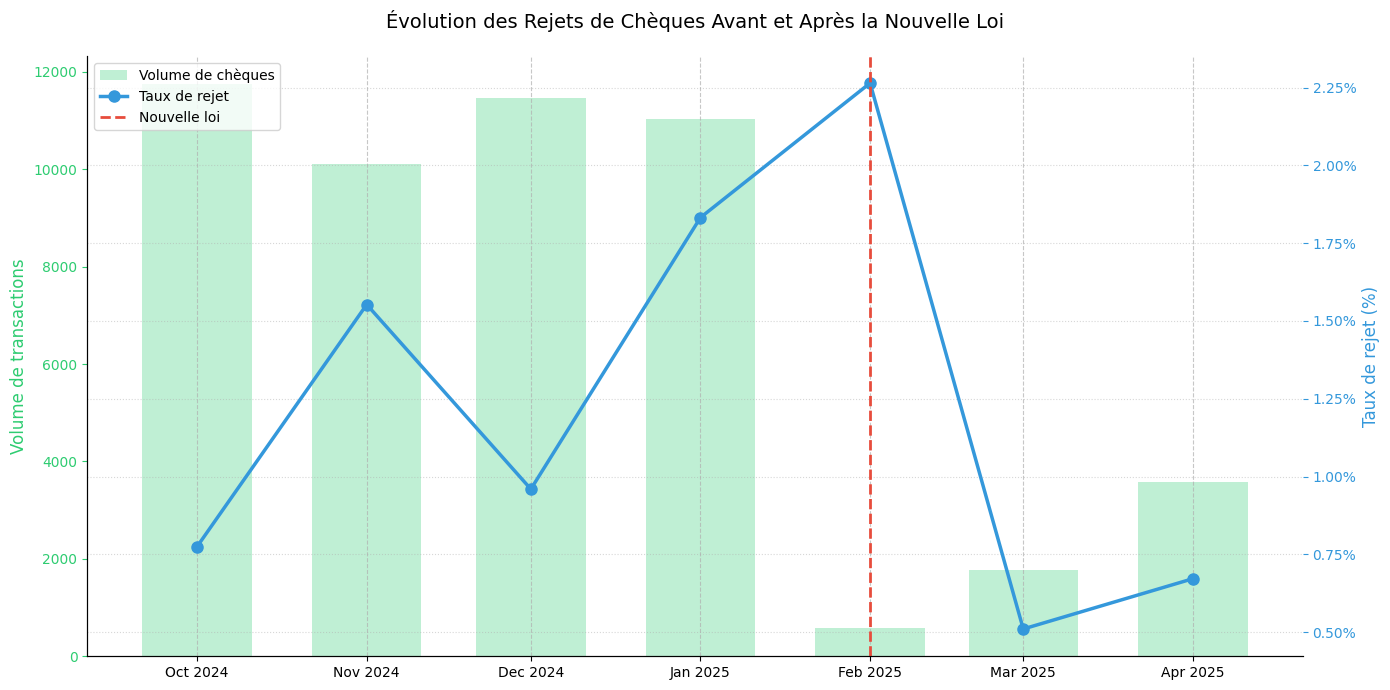

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# Prepare data
df1_mois = df1.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
df1_mois['DATE'] = pd.to_datetime(df1_mois['ANNEE'].astype(str) + '-' + df1_mois['MOIS'].astype(str))
df1_mois['TAUX_REJET'] = df1_mois['SORT'] * 100

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Custom color palette
line_color = '#3498db'  # Professional blue
bar_color = '#2ecc71'   # Professional green
law_line_color = '#e74c3c'  # Attention-grabbing red

# Bar chart (monthly volumes)
ax1.bar(df1_mois['DATE'], df1.groupby(['ANNEE', 'MOIS'])['SORT'].count().values,
        color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
ax1.set_ylabel('Volume de transactions', fontsize=12)
ax1.yaxis.label.set_color(bar_color)
ax1.tick_params(axis='y', colors=bar_color)

# Line chart (rejection rate)
ax2 = ax1.twinx()
ax2.plot(df1_mois['DATE'], df1_mois['TAUX_REJET'],
         color=line_color, marker='o', markersize=8,
         linewidth=2.5, label='Taux de rejet')
ax2.set_ylabel('Taux de rejet (%)', fontsize=12)
ax2.yaxis.label.set_color(line_color)
ax2.tick_params(axis='y', colors=line_color)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Law change marker
ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
           linestyle='--', linewidth=2, label='Nouvelle loi')

# Formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Évolution des Rejets de Chèques Avant et Après la Nouvelle Loi', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add data labels for peaks
max_rejet = df1_mois['TAUX_REJET'].max()
if max_rejet > 10:  # Only label if significant
    max_date = df1_mois.loc[df1_mois['TAUX_REJET'].idxmax(), 'DATE']
    ax2.annotate(f'Pic: {max_rejet:.1f}%', xy=(max_date, max_rejet),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 arrowprops=dict(arrowstyle='->'))

# Add grid and style
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [49]:
# Convertir 'DATECPS' en datetime et extraire l'année/mois
df2['DATECPS'] = pd.to_datetime(df2['DATECPS'])
df2['ANNEE'] = df2['DATECPS'].dt.year
df2['MOIS'] = df2['DATECPS'].dt.month

# Filtrer les données avant/après la loi (ex: loi appliquée en 2024)
df2_avant = df2[df2['DATECPS'] < date_loi]
df2_apres = df2[df2['DATECPS'] >= date_loi]

# Calculer le taux de rejet global avant/après
taux2_avant = df2_avant['SORT'].mean() * 100
taux2_apres = df2_apres['SORT'].mean() * 100

print(f"Taux de rejet avant la loi : {taux2_avant:.2f}%")
print(f"Taux de rejet après la loi : {taux2_apres:.2f}%")



Taux de rejet avant la loi : 30.70%
Taux de rejet après la loi : 26.93%


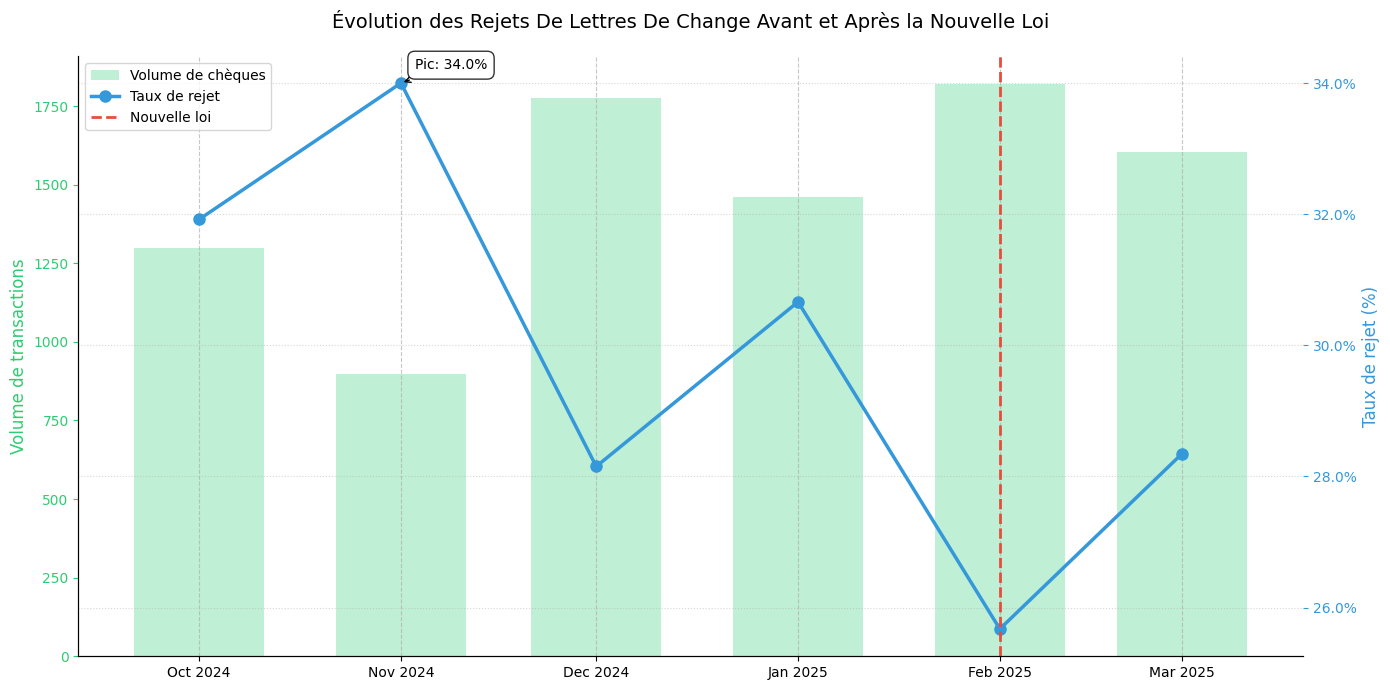

In [50]:
# Prepare data
df2_mois = df2.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
df2_mois['DATE'] = pd.to_datetime(df2_mois['ANNEE'].astype(str) + '-' + df2_mois['MOIS'].astype(str))
df2_mois['TAUX_REJET'] = df2_mois['SORT'] * 100

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Custom color palette
line_color = '#3498db'  # Professional blue
bar_color = '#2ecc71'   # Professional green
law_line_color = '#e74c3c'  # Attention-grabbing red

# Bar chart (monthly volumes)
ax1.bar(df2_mois['DATE'], df2.groupby(['ANNEE', 'MOIS'])['SORT'].count().values,
        color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
ax1.set_ylabel('Volume de transactions', fontsize=12)
ax1.yaxis.label.set_color(bar_color)
ax1.tick_params(axis='y', colors=bar_color)

# Line chart (rejection rate)
ax2 = ax1.twinx()
ax2.plot(df2_mois['DATE'], df2_mois['TAUX_REJET'],
         color=line_color, marker='o', markersize=8,
         linewidth=2.5, label='Taux de rejet')
ax2.set_ylabel('Taux de rejet (%)', fontsize=12)
ax2.yaxis.label.set_color(line_color)
ax2.tick_params(axis='y', colors=line_color)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Law change marker
ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
           linestyle='--', linewidth=2, label='Nouvelle loi')

# Formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Évolution des Rejets De Lettres De Change Avant et Après la Nouvelle Loi', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add data labels for peaks
max_rejet = df2_mois['TAUX_REJET'].max()
if max_rejet > 10:  # Only label if significant
    max_date = df2_mois.loc[df2_mois['TAUX_REJET'].idxmax(), 'DATE']
    ax2.annotate(f'Pic: {max_rejet:.1f}%', xy=(max_date, max_rejet),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 arrowprops=dict(arrowstyle='->'))

# Add grid and style
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

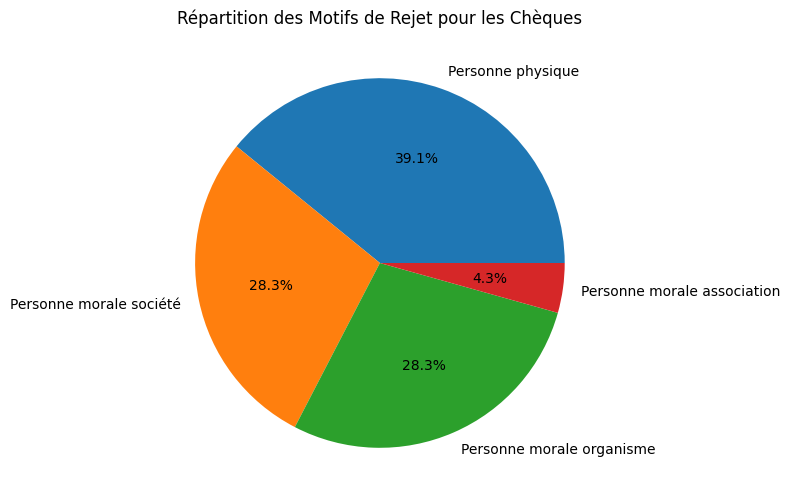

In [51]:
plt.figure(figsize=(10, 6))
df1_apres[df1_apres['SORT'] == 1]['LIBCCL'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des Motifs de Rejet pour les Chèques')
plt.ylabel('')
plt.show()

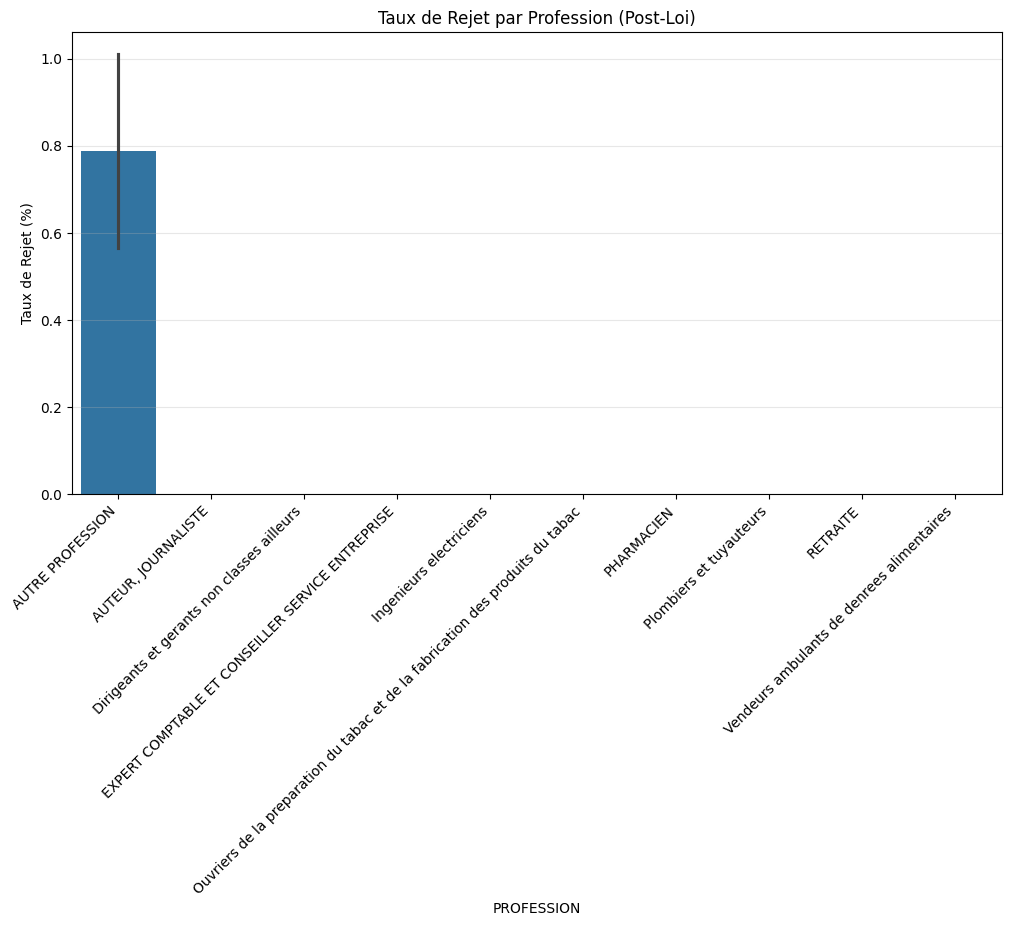

In [53]:
plt.figure(figsize=(12,6))
sns.barplot(data=df1_apres, x='PROFESSION', y='SORT', estimator=lambda x: sum(x)/len(x)*100,
            order=df1_apres.groupby('PROFESSION')['SORT'].mean().sort_values(ascending=False).index)
plt.title('Taux de Rejet par Profession (Post-Loi)')
plt.ylabel('Taux de Rejet (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

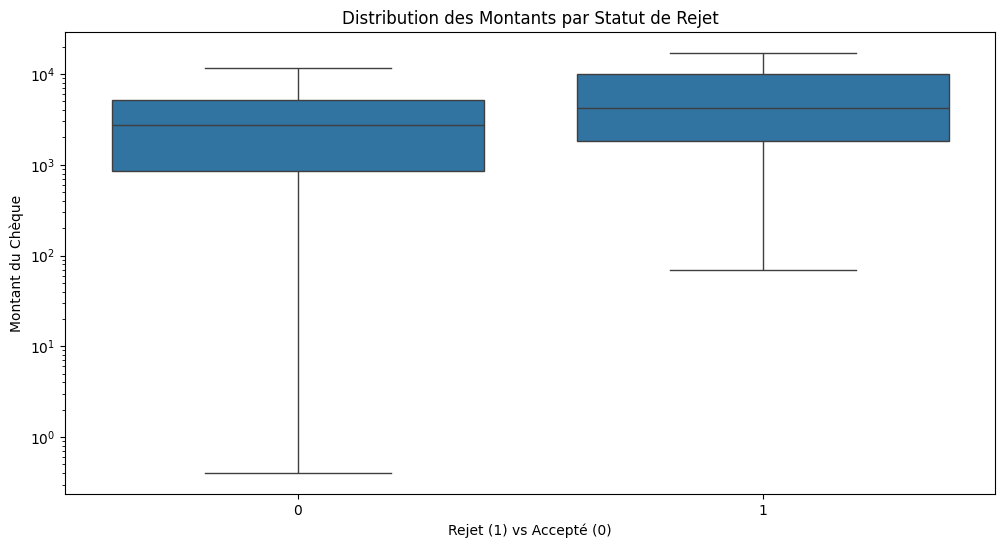

In [54]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df1_apres, x='SORT', y='MNT', showfliers=False)
plt.title('Distribution des Montants par Statut de Rejet')
plt.xlabel('Rejet (1) vs Accepté (0)')
plt.ylabel('Montant du Chèque')
plt.yscale('log')  # For better visualization of wide ranges
plt.show()

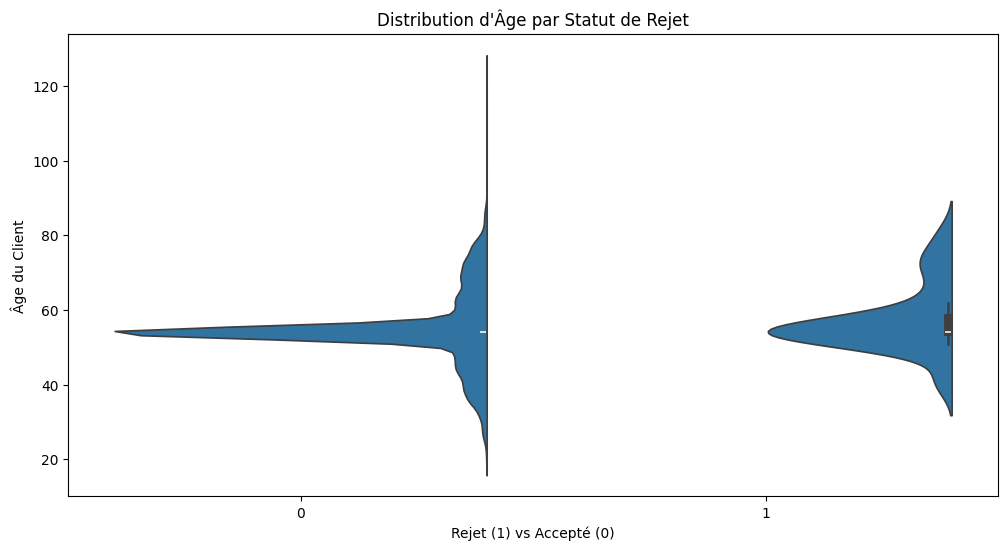

In [37]:

plt.figure(figsize=(12,6))
sns.violinplot(data=df1_apres, x='SORT', y='AGE', split=True)
plt.title('Distribution d\'Âge par Statut de Rejet')
plt.xlabel('Rejet (1) vs Accepté (0)')
plt.ylabel('Âge du Client')
plt.show()

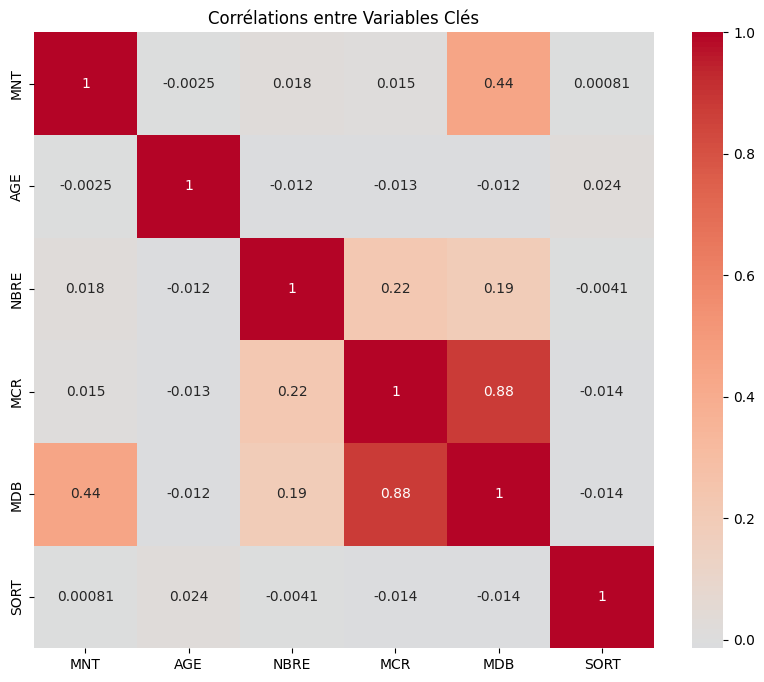

In [38]:
# Select relevant numerical columns
corr_cols = ['MNT', 'AGE', 'NBRE', 'MCR', 'MDB', 'SORT']
plt.figure(figsize=(10,8))
sns.heatmap(df1_apres[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations entre Variables Clés')
plt.show()

In [39]:

top_reasons = df1_apres['LIBCCL'].value_counts().nlargest(5).index
reason_evolution = df1_apres[df1_apres['DATE'] >= '2025-01-01'].groupby(
    [pd.Grouper(key='DATE', freq='M'), 'LIBCCL']
)['SORT'].sum().unstack()[top_reasons]

plt.figure(figsize=(14,7))
reason_evolution.plot(kind='area', alpha=0.8)
plt.axvline(pd.to_datetime(date_loi), color='red', linestyle='--')
plt.title('Évolution des Principaux Motifs de Rejet')
plt.ylabel('Nombre de Rejets')
plt.xlabel('Date')
plt.legend(title='Motif', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

KeyError: 'DATE'

In [55]:
df1.head()

,NBRE,MCR,MDB,VALEUR,DATECPS,NUM,MNT,ID,DNA,PROVISIONNE,PROFESSION,LIBCCL,SORT,AGE,le_PROFESSION,le_LIBCCL,ANNEE,MOIS
0,42.0,18274.785,18896.693,30,2024-10-01,5687977,300.0,1994064,1980-08-28,0,AUTRE PROFESSION,Personne physique,0,44.000000,1,3,2024,10
1,768.0,6669595.616,7392793.016,30,2024-10-01,6690327,3213.0,1999037,NaT,0,AUTRE PROFESSION,Personne morale société,0,53.997732,1,2,2024,10
2,102.0,10060.215,12062.296,30,2024-10-01,6474297,100.0,2083314,1976-11-18,0,AUTRE PROFESSION,Personne physique,0,48.000000,1,3,2024,10
3,120.0,21432.459,23465.461,30,2024-10-01,6067813,200.0,1018499,1981-06-26,0,AUTRE PROFESSION,Personne physique,0,43.000000,1,3,2024,10
4,120.0,21432.459,23465.461,30,2024-10-01,6067805,1100.0,1018499,1981-06-26,0,AUTRE PROFESSION,Personne physique,0,43.000000,1,3,2024,10


In [ ]:
# Prepare data
df2_mois = df2.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
df2_mois['DATE'] = pd.to_datetime(df2_mois['ANNEE'].astype(str) + '-' + df2_mois['MOIS'].astype(str))
df2_mois['TAUX_REJET'] = df2_mois['SORT'] * 100

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Custom color palette
line_color = '#3498db'  # Professional blue
bar_color = '#2ecc71'   # Professional green
law_line_color = '#e74c3c'  # Attention-grabbing red

# Bar chart (monthly volumes)
ax1.bar(df2_mois['DATE'], df2.groupby(['ANNEE', 'MOIS'])['SORT'].count().values,
        color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
ax1.set_ylabel('Volume de transactions', fontsize=12)
ax1.yaxis.label.set_color(bar_color)
ax1.tick_params(axis='y', colors=bar_color)

# Line chart (rejection rate)
ax2 = ax1.twinx()
ax2.plot(df2_mois['DATE'], df2_mois['TAUX_REJET'],
         color=line_color, marker='o', markersize=8,
         linewidth=2.5, label='Taux de rejet')
ax2.set_ylabel('Taux de rejet (%)', fontsize=12)
ax2.yaxis.label.set_color(line_color)
ax2.tick_params(axis='y', colors=line_color)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Law change marker
ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
           linestyle='--', linewidth=2, label='Nouvelle loi')

# Formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Évolution des Rejets De Lettres De Change Avant et Après la Nouvelle Loi', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add data labels for peaks
max_rejet = df2_mois['TAUX_REJET'].max()
if max_rejet > 10:  # Only label if significant
    max_date = df2_mois.loc[df2_mois['TAUX_REJET'].idxmax(), 'DATE']
    ax2.annotate(f'Pic: {max_rejet:.1f}%', xy=(max_date, max_rejet),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 arrowprops=dict(arrowstyle='->'))

# Add grid and style
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()


###
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# Prepare data
df1_mois = df1.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
df1_mois['DATE'] = pd.to_datetime(df1_mois['ANNEE'].astype(str) + '-' + df1_mois['MOIS'].astype(str))
df1_mois['TAUX_REJET'] = df1_mois['SORT'] * 100

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Custom color palette
line_color = '#3498db'  # Professional blue
bar_color = '#2ecc71'   # Professional green
law_line_color = '#e74c3c'  # Attention-grabbing red

# Bar chart (monthly volumes)
ax1.bar(df1_mois['DATE'], df1.groupby(['ANNEE', 'MOIS'])['SORT'].count().values,
        color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
ax1.set_ylabel('Volume de transactions', fontsize=12)
ax1.yaxis.label.set_color(bar_color)
ax1.tick_params(axis='y', colors=bar_color)

# Line chart (rejection rate)
ax2 = ax1.twinx()
ax2.plot(df1_mois['DATE'], df1_mois['TAUX_REJET'],
         color=line_color, marker='o', markersize=8,
         linewidth=2.5, label='Taux de rejet')
ax2.set_ylabel('Taux de rejet (%)', fontsize=12)
ax2.yaxis.label.set_color(line_color)
ax2.tick_params(axis='y', colors=line_color)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Law change marker
ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
           linestyle='--', linewidth=2, label='Nouvelle loi')

# Formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Évolution des Rejets de Chèques Avant et Après la Nouvelle Loi', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add data labels for peaks
max_rejet = df1_mois['TAUX_REJET'].max()
if max_rejet > 10:  # Only label if significant
    max_date = df1_mois.loc[df1_mois['TAUX_REJET'].idxmax(), 'DATE']
    ax2.annotate(f'Pic: {max_rejet:.1f}%', xy=(max_date, max_rejet),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 arrowprops=dict(arrowstyle='->'))

# Add grid and style
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

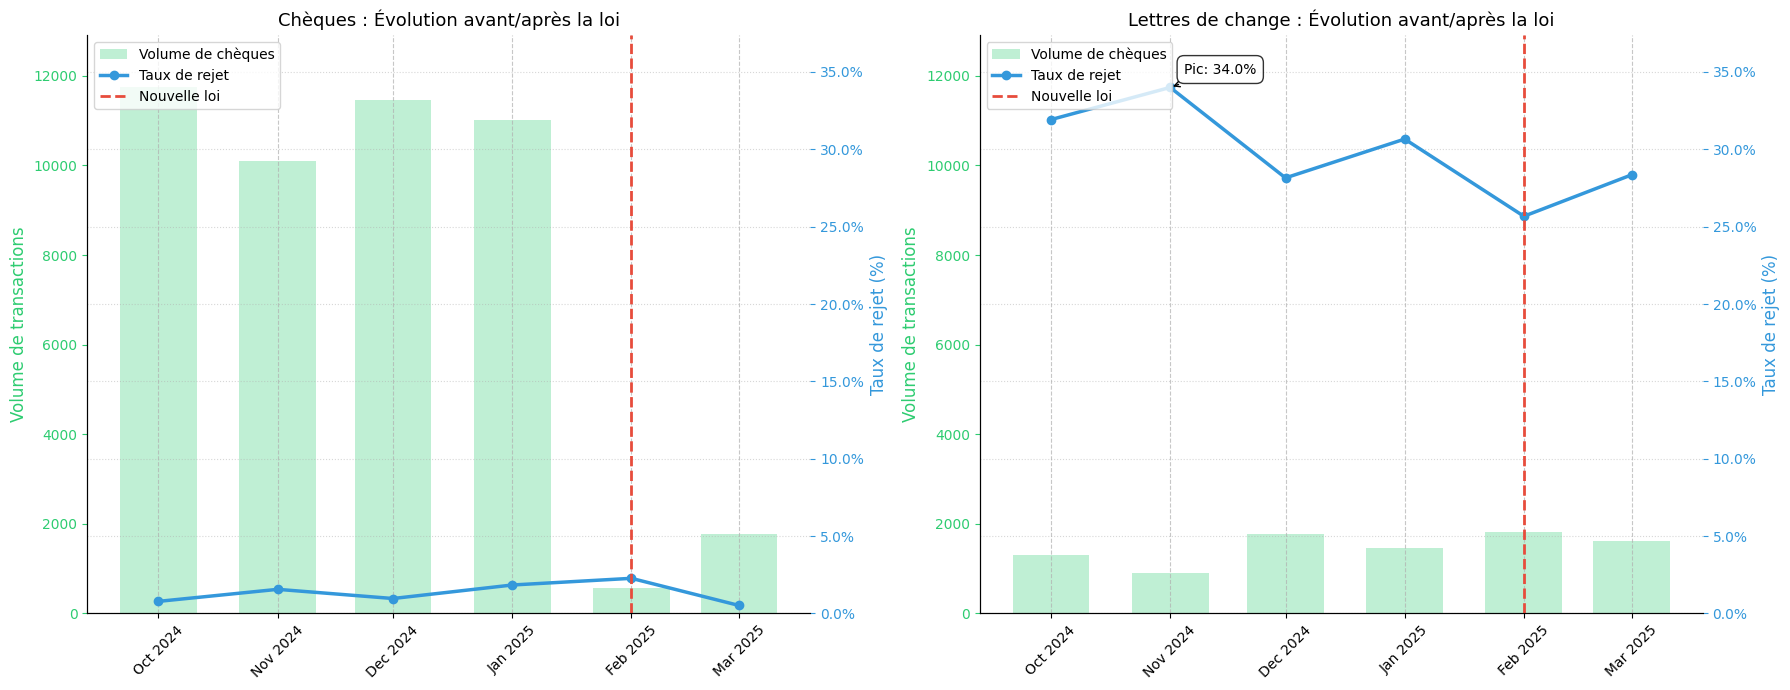

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import pandas as pd

# === Preprocessing Shared Function ===
def preprocess_monthly_data(df):
    df_mois = df.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
    df_mois['DATE'] = pd.to_datetime(df_mois['ANNEE'].astype(str) + '-' + df_mois['MOIS'].astype(str))
    df_mois['TAUX_REJET'] = df_mois['SORT'] * 100
    df_mois['VOLUME'] = df.groupby(['ANNEE', 'MOIS'])['SORT'].count().values
    # Filter from October to March
    df_mois = df_mois[df_mois['DATE'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    return df_mois

# === Preprocess both datasets ===
df1_mois = preprocess_monthly_data(df1)
df2_mois = preprocess_monthly_data(df2)

# Get shared y-limits
volume_max = max(df1_mois['VOLUME'].max(), df2_mois['VOLUME'].max())
taux_max = max(df1_mois['TAUX_REJET'].max(), df2_mois['TAUX_REJET'].max())

# === Create Side-by-Side Subplots ===
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

# --- Plot Function ---
def plot_dual_axis(ax, data, title, date_loi):
    line_color = '#3498db'
    bar_color = '#2ecc71'
    law_line_color = '#e74c3c'

    # Bar chart (volume)
    ax1 = ax
    ax1.bar(data['DATE'], data['VOLUME'],
            color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
    ax1.set_ylabel('Volume de transactions', fontsize=12, color=bar_color)
    ax1.tick_params(axis='y', colors=bar_color)
    ax1.set_ylim(0, volume_max * 1.1)

    # Line chart (rejection rate)
    ax2 = ax1.twinx()
    ax2.plot(data['DATE'], data['TAUX_REJET'],
             color=line_color, marker='o', markersize=6,
             linewidth=2.5, label='Taux de rejet')
    ax2.set_ylabel('Taux de rejet (%)', fontsize=12, color=line_color)
    ax2.tick_params(axis='y', colors=line_color)
    ax2.set_ylim(0, taux_max * 1.1)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # Law change marker
    ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
               linestyle='--', linewidth=2, label='Nouvelle loi')

    # Formatting
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.set_title(title, fontsize=13)
    ax1.tick_params(axis='x', rotation=45)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Annotate peak
    max_rejet = data['TAUX_REJET'].max()
    if max_rejet > 10:
        max_date = data.loc[data['TAUX_REJET'].idxmax(), 'DATE']
        ax2.annotate(f'Pic: {max_rejet:.1f}%',
                     xy=(max_date, max_rejet),
                     xytext=(10, 10), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                     arrowprops=dict(arrowstyle='->'))

    # Grid
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    ax2.grid(axis='y', linestyle=':', alpha=0.5)

# === Plot Both Figures ===
plot_dual_axis(axes[0], df1_mois, 'Chèques : Évolution avant/après la loi', date_loi)
plot_dual_axis(axes[1], df2_mois, 'Lettres de change : Évolution avant/après la loi', date_loi)

sns.despine()
plt.tight_layout()
plt.show()


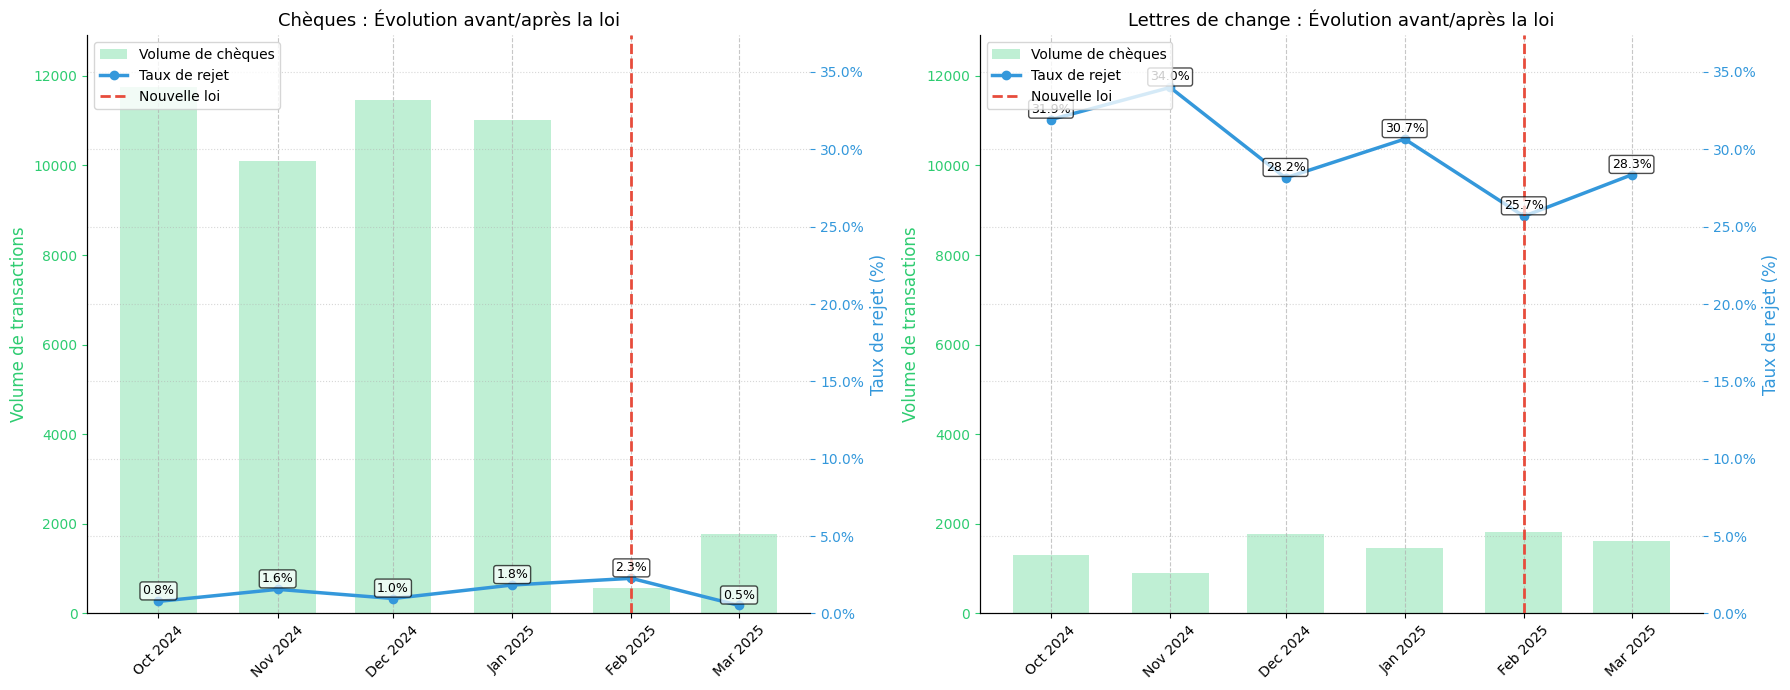

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import pandas as pd

# === Preprocessing Shared Function ===
def preprocess_monthly_data(df):
    df_mois = df.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
    df_mois['DATE'] = pd.to_datetime(df_mois['ANNEE'].astype(str) + '-' + df_mois['MOIS'].astype(str))
    df_mois['TAUX_REJET'] = df_mois['SORT'] * 100
    df_mois['VOLUME'] = df.groupby(['ANNEE', 'MOIS'])['SORT'].count().values
    # Filter from October to March
    df_mois = df_mois[df_mois['DATE'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    return df_mois

# === Preprocess both datasets ===
df1_mois = preprocess_monthly_data(df1)
df2_mois = preprocess_monthly_data(df2)

# Get shared y-limits
volume_max = max(df1_mois['VOLUME'].max(), df2_mois['VOLUME'].max())
taux_max = max(df1_mois['TAUX_REJET'].max(), df2_mois['TAUX_REJET'].max())

# === Create Side-by-Side Subplots ===
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

# --- Plot Function ---
def plot_dual_axis(ax, data, title, date_loi):
    line_color = '#3498db'
    bar_color = '#2ecc71'
    law_line_color = '#e74c3c'

    # Bar chart (volume)
    ax1 = ax
    ax1.bar(data['DATE'], data['VOLUME'],
            color=bar_color, alpha=0.3, width=20, label='Volume de chèques')
    ax1.set_ylabel('Volume de transactions', fontsize=12, color=bar_color)
    ax1.tick_params(axis='y', colors=bar_color)
    ax1.set_ylim(0, volume_max * 1.1)

    # Line chart (rejection rate)
    ax2 = ax1.twinx()
    ax2.plot(data['DATE'], data['TAUX_REJET'],
             color=line_color, marker='o', markersize=6,
             linewidth=2.5, label='Taux de rejet')
    ax2.set_ylabel('Taux de rejet (%)', fontsize=12, color=line_color)
    ax2.tick_params(axis='y', colors=line_color)
    ax2.set_ylim(0, taux_max * 1.1)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # === Add percentage labels above each point ===
    for x, y in zip(data['DATE'], data['TAUX_REJET']):
        ax2.annotate(f'{y:.1f}%', xy=(x, y), xytext=(0, 5),
                     textcoords='offset points', ha='center', fontsize=9,
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

    # Law change marker
    ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
               linestyle='--', linewidth=2, label='Nouvelle loi')

    # Formatting
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.set_title(title, fontsize=13)
    ax1.tick_params(axis='x', rotation=45)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Grid
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    ax2.grid(axis='y', linestyle=':', alpha=0.5)

# === Plot Both Figures ===
plot_dual_axis(axes[0], df1_mois, 'Chèques : Évolution avant/après la loi', date_loi)
plot_dual_axis(axes[1], df2_mois, 'Lettres de change : Évolution avant/après la loi', date_loi)

sns.despine()
plt.tight_layout()
plt.show()


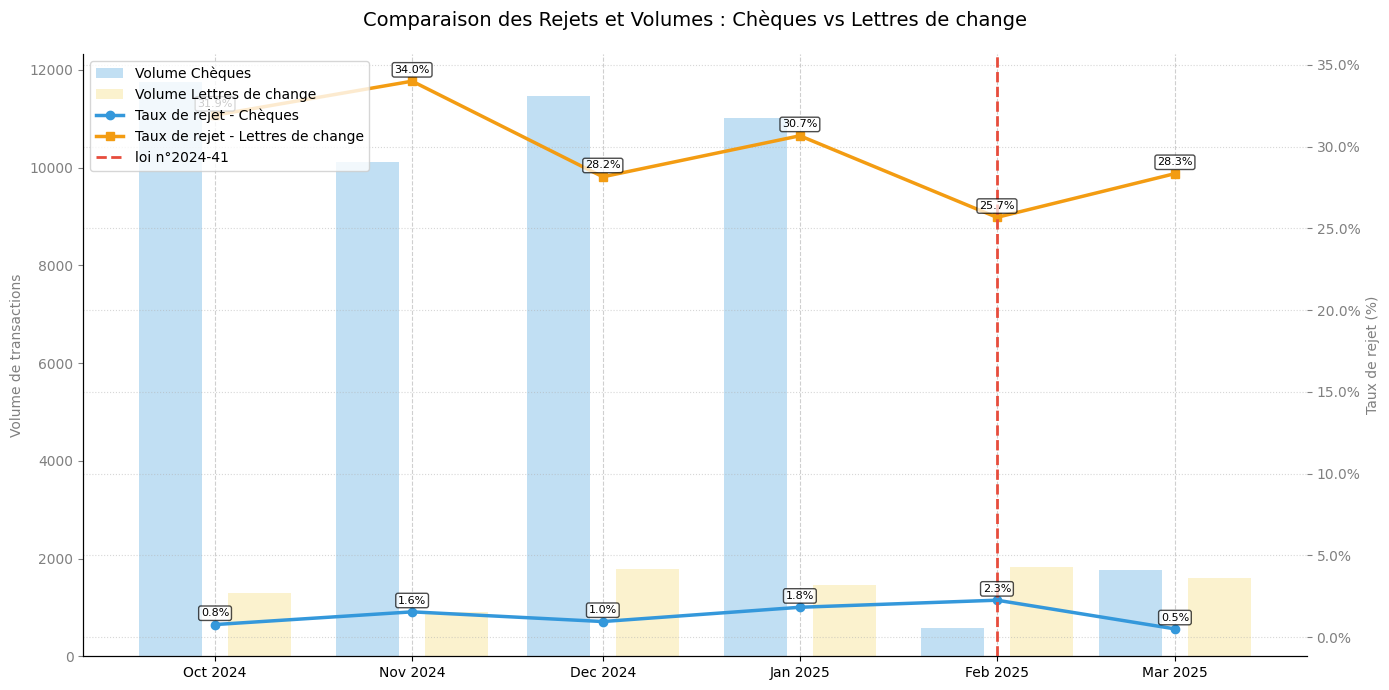

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import pandas as pd

# === Preprocessing Function ===
def preprocess_monthly_data(df):
    df_mois = df.groupby(['ANNEE', 'MOIS'])['SORT'].mean().reset_index()
    df_mois['DATE'] = pd.to_datetime(df_mois['ANNEE'].astype(str) + '-' + df_mois['MOIS'].astype(str))
    df_mois['TAUX_REJET'] = df_mois['SORT'] * 100
    df_mois['VOLUME'] = df.groupby(['ANNEE', 'MOIS'])['SORT'].count().values
    df_mois = df_mois[df_mois['DATE'].dt.month.isin([10, 11, 12, 1, 2, 3])]
    return df_mois

# === Prepare data
df1_mois = preprocess_monthly_data(df1)  # chèques
df2_mois = preprocess_monthly_data(df2)  # lettres de change

# === Align dates (optional but safe)
common_dates = sorted(set(df1_mois['DATE']).intersection(df2_mois['DATE']))
df1_mois = df1_mois[df1_mois['DATE'].isin(common_dates)]
df2_mois = df2_mois[df2_mois['DATE'].isin(common_dates)]

# === Plot ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colors
cheque_color = '#3498db'
lettre_color = '#f39c12'
volume_cheque_color = '#85C1E9'
volume_lettre_color = '#F9E79F'
law_line_color = '#e74c3c'

# === Bar Charts for Volume ===
bar_width = 10  # reduce width for side-by-side
ax1.bar(df1_mois['DATE'] - pd.Timedelta(days=7), df1_mois['VOLUME'],
        width=bar_width, color=volume_cheque_color, alpha=0.5, label='Volume Chèques')
ax1.bar(df2_mois['DATE'] + pd.Timedelta(days=7), df2_mois['VOLUME'],
        width=bar_width, color=volume_lettre_color, alpha=0.5, label='Volume Lettres de change')

ax1.set_ylabel('Volume de transactions', color='gray')
ax1.tick_params(axis='y', colors='gray')

# === Line Plot for Taux de Rejet (second axis)
ax2 = ax1.twinx()

# Chèques
ax2.plot(df1_mois['DATE'], df1_mois['TAUX_REJET'], marker='o', linewidth=2.5,
         color=cheque_color, label='Taux de rejet - Chèques')

# Lettres de change
ax2.plot(df2_mois['DATE'], df2_mois['TAUX_REJET'], marker='s', linewidth=2.5,
         color=lettre_color, label='Taux de rejet - Lettres de change')

# Add percentage annotations
for x, y in zip(df1_mois['DATE'], df1_mois['TAUX_REJET']):
    ax2.annotate(f'{y:.1f}%', xy=(x, y), xytext=(0, 6),
                 textcoords='offset points', ha='center',
                 fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

for x, y in zip(df2_mois['DATE'], df2_mois['TAUX_REJET']):
    ax2.annotate(f'{y:.1f}%', xy=(x, y), xytext=(0, 6),
                 textcoords='offset points', ha='center',
                 fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

ax2.set_ylabel('Taux de rejet (%)', color='gray')
ax2.tick_params(axis='y', colors='gray')
ax2.yaxis.set_major_formatter(PercentFormatter())

# === Law change line
ax2.axvline(pd.to_datetime(date_loi), color=law_line_color,
            linestyle='--', linewidth=2, label='loi n°2024-41')

# === Format X-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')

# === Title and Legend
plt.title("Comparaison des Rejets et Volumes : Chèques vs Lettres de change", fontsize=14, pad=20)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# === Grid and Styling
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()
